# Градиентный бустинг

Этот семинар посвящен градиентному бустингу — от основ до практического применения. На примере прогнозирования зарплат в Data Science мы сравниваем производительность и качество моделей (линейная регрессия, kNN, случайный лес, бустинг), изучаем принципы работы AdaBoost и градиентного бустинга на синтетических данных, анализируем bias-variance разложение и склонность к переобучению, оцениваем влияние гиперпараметров на скорость и точность предсказаний, а также проводим оптимизацию модели с помощью RandomizedSearchCV для достижения наилучшего баланса между качеством и вычислительной эффективностью.

In [1]:
import numpy as np
import pandas as pd
import time
import joblib
import os
import scipy
from typing import Callable, TypeVar, Any, Tuple, cast, List, Dict, Sequence, Optional, Union

from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
import seaborn as sns
import scipy.stats as sps
from scipy.stats import t, norm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_moons
from sklearn.metrics import mean_squared_error as mse
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder

sns.set(font_scale=1.8, palette="Set2")
RANDOM_STATE = 42

## 1. Введение

### 1.1 Предсказания зарплат в DataScience

Давайте вспомним наконец-то зачем мы все здесь с вами собрались. Конечно же за 300к\наносек! Но что нам мешает просто предказать свою будущую ЗП?

[Data Science Salaries 2024 💸](https://www.kaggle.com/datasets/fahadrehman07/data-science-jobs-and-salary-glassdoor) &mdash; Датасет
содержит информацию о вакансиях в области Data Science с 2020 по 2024 года, собранную с платформы Glassdoor. Этот набор данных предоставляет ценные сведения о рынке труда для специалистов по данным, включая позиции, компании, локации, зарплаты и другую связанную информацию:

* `Job Title` &mdash; Название должности
* `Salary Estimate` &mdash; Предполагаемая заработная плата за работу, которую предоставляет компания
* `Job Description` &mdash; Описания рабочих обязанностей
* `Rating` &mdash; Рейтинг компании
* `Company Name` &mdash; Название компании
* `Location` &mdash; Место работы
* `Headquarters` &mdash; Расположение штаб-квартиры компании
* `Size` &mdash; Число сотрудников в компании
* `Founded` &mdash; Год в котором компания была основана
* `Type of ownership` &mdash; Форма собственности, такие как частная, государственная и некоммерческие организации.
* `Industry` &mdash; Тип отрасли, например, аэрокосмическая, энергетика, где компания предоставляет услуги.
* `Sector` &mdash; Какой тип услуг компания предоставляет в отрасли, например, отрасль (Энергетика), сектор (Нефть, Газ).
* `Revenue` &mdash; Общий доход компании
* `Competitors` &mdash; Конкуренты у данной компании



In [2]:
salary = pd.read_csv("Glassdoor_Salary_Cleaned_Version.csv")
salary.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,...,avg_salary,company_txt,job_state,same_state,age,python_yn,R_yn,spark,aws,excel
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,...,72.0,Tecolote Research\n,NM,0,47,1,0,0,0,1
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,...,87.5,University of Maryland Medical System\n,MD,0,36,1,0,0,0,0
2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,...,85.0,KnowBe4\n,FL,1,10,1,0,1,0,1
3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,...,76.5,PNNL\n,WA,1,55,1,0,0,0,0
4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,...,114.5,Affinity Solutions\n,NY,1,22,1,0,0,0,1


Посмотрим на размерность данных

In [3]:
salary.shape

(742, 28)

### 1.2 Предобработка данных

Как мы видим, в данном датасете много категориальных признаков, которые мы не можем выкинуть просто так и с ними надо отдельно поработать.

Посмотрим на столбец `Competitors`, где перечислены названия компаний-конкурентов или отсутствие таковых (`-1`)

In [4]:
salary[["Competitors"]].head()

,Competitors
0,-1
1,-1
2,-1
3,"Oak Ridge National Laboratory, National Renewa..."
4,"Commerce Signals, Cardlytics, Yodlee"


Так как сами названия компаний нам ничего не дадут, здесь имеет смысл указать число конкурентов.


In [5]:
salary["Num_comp"] = salary["Competitors"].apply(lambda x: len(x.split(",")) if x != "-1" else 0)
salary[["Competitors", "Num_comp"]].head()

,Competitors,Num_comp
0,-1,0
1,-1,0
2,-1,0
3,"Oak Ridge National Laboratory, National Renewa...",3
4,"Commerce Signals, Cardlytics, Yodlee",3


Так же посмотрим на признак `Job Title`

In [6]:
salary["Job Title"].unique()[:10]

array(['Data Scientist', 'Healthcare Data Scientist',
       'Research Scientist', 'Staff Data Scientist - Technology',
       'Data Analyst', 'Data Engineer I', 'Scientist I/II, Biology',
       'Customer Data Scientist',
       'Data Scientist - Health Data Analytics',
       'Senior Data Scientist / Machine Learning'], dtype=object)

Слишком большой и разнообразный список, попробуем упростить. Обощим все на 7 категорий:
* `data scientist` &mdash; Дата сайентист
* `data engineer` &mdash; Дата инженер
* `analyst` &mdash; аналитик
* `mle` &mdash; ML-инженер
* `manager` &mdash; менеджер
* `director` &mdash; директор
* `na` &mdash; все остальное  

Так же, поскольку в данном столбце указана квалификация сотрудника, введем дополнительный признак, который будет отличать джунов от сеньоров.

* `senior` &mdash; Cеньор
* `jr` &mdash; Джун
* `na`  &mdash; все остальное


In [7]:
def title_simplifier(title: str) -> str:
    """
    Определяет категорию должности сотрудника на основе ключевых слов в названии.

    Анализирует строку с должностью и возвращает обобщенную категорию.
    Регистр символов не учитывается.

    Параметры:
    - title (str): Название должности для анализа (например, "Senior Data Scientist").

    Возращает:
    - str: Одна из 7 категорий:
          - 'data scientist' — если найдено "data scientist"
          - 'data engineer' — если найдено "data engineer"
          - 'analyst' — если найдено "analyst"
          - 'mle' — если найдено "machine learning"
          - 'manager' — если найдено "manager"
          - 'director' — если найдено "director"
          - 'na' — если ни одно ключевое слово не найдено.
    """

    title = title.lower()

    if "data scientist" in title:
        return "data scientist"
    elif "data engineer" in title:
        return "data engineer"
    elif "analyst" in title:
        return "analyst"
    elif "machine learning" in title:
        return "mle"
    elif "manager" in title:
        return "manager"
    elif "director" in title:
        return "director"
    else:
        return "na"


def seniority(title: str) -> str:
    """
    Определяет уровень seniority сотрудника на основе ключевых слов в должности.

    Анализирует строку с должностью и возвращает уровень опыта.
    Регистр символов не учитывается.

    Параметры:
    - title (str): Название должности для анализа (например, "Jr. Data Analyst").

    Возращает:
    - str: Одна из 3 категорий:
          - 'senior' — для Senior/Lead/Principal ролей.
          - 'jr' — для Junior позиций.
          - 'na' — если уровень не определен.
    """
    title = title.lower()

    if "sr" in title or "senior" in title or "lead" in title or "principal" in title:
        return "senior"
    elif "jr" in title or "jr." in title:
        return "jr"
    else:
        return "na"

Создадим новые признаки на основе признака `Job Title`

In [8]:
salary["Job_simp"] = salary["Job Title"].apply(title_simplifier)
salary["seniority"] = salary["Job Title"].apply(seniority)



- Средняя зарплата &mdash; наш таргет `avg_salary`  


Оставим для обучения только часть прзнаков:


* Данные компании:
    - Рейтинг `Rating`
    - Размер  по числу сотруднико`Size`
    - Доход компании за год `Revenue`
    - Возраст компании `age`
    -  Форма собственности бизнесса (public, private, goverment)`Type of ownership`
    - Отрасль `Industry` и вид услуг  данной отрасли `Sector`
    - Число конкуренто у этой компании `Num_comp`

* Тип трудоустройства:
    - `hourly`
    - Штат в котором расположена Штаб-квартира компании`job_state` и совпадает ли место работы с этим штатом `same_state`

* Данные сотрудника:
    - Набор фреймворков/ЯП которыми владеет сотрудник  `python_yn` `spark` `aws` `excel`
    - Упрощенные нами ранее данные о должности и квалификации сотрудника `Job_simp` и  `seniority`

In [9]:
salary_model = salary[
    [
        "avg_salary",
        "Rating",
        "Size",
        "Type of ownership",
        "Industry",
        "Sector",
        "Revenue",
        "Num_comp",
        "hourly",
        "job_state",
        "same_state",
        "age",
        "python_yn",
        "spark",
        "aws",
        "excel",
        "Job_simp",
        "seniority",
    ]
]
salary_model.head()

,avg_salary,Rating,Size,Type of ownership,Industry,Sector,Revenue,Num_comp,hourly,job_state,same_state,age,python_yn,spark,aws,excel,Job_simp,seniority
0,72.0,3.8,501 to 1000 employees,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),0,0,NM,0,47,1,0,0,1,data scientist,na
1,87.5,3.4,10000+ employees,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),0,0,MD,0,36,1,0,0,0,data scientist,na
2,85.0,4.8,501 to 1000 employees,Company - Private,Security Services,Business Services,$100 to $500 million (USD),0,0,FL,1,10,1,1,0,1,data scientist,na
3,76.5,3.8,1001 to 5000 employees,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),3,0,WA,1,55,1,0,0,0,data scientist,na
4,114.5,2.9,51 to 200 employees,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,3,0,NY,1,22,1,0,0,1,data scientist,na


Выделим таргет, заэнкодим категориальные переменные и разобьем данные на трейн и тест.

In [10]:
# Исходные данные (без кодирования)
X = salary_model.drop("avg_salary", axis=1)
y = salary_model["avg_salary"].values

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Получаем все возможные категории из тренировочного набора
train_dummies = pd.get_dummies(X_train)
test_dummies = pd.get_dummies(X_test)

# Синхронизируем столбцы (добавляем отсутствующие в test с нулями)
X_train_encoded = train_dummies
X_test_encoded = test_dummies.reindex(columns=train_dummies.columns, fill_value=0)

Посмотрим на размерность данных после энкодинга.

In [11]:
X_train_encoded.shape, X_train.shape

((593, 174), (593, 17))

### 1.3 Обучение модели

Посмотрим как с этой задачей справится обычная линейная регрессия.

In [12]:
linreg = LinearRegression().fit(X_train_encoded, y_train)
print(f" R2 = {r2_score(y_test, linreg.predict(X_test_encoded)):.3f}")
print(f"MAPE = {mean_absolute_percentage_error(y_test, linreg.predict(X_test_encoded)):.3f}")

 R2 = 0.569
MAPE = 0.206


Попробуем сравниться с knn, как с типичным представителем еще одного класса известных моделей

In [13]:
scaler = StandardScaler().fit(X_train_encoded)
X_train_scaled = scaler.transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

knn = KNeighborsRegressor().fit(X_train_encoded, y_train)
print(f" R2 = {r2_score(y_test, knn.predict(X_test_encoded)):.3f}")
print(f"MAPE = {mean_absolute_percentage_error(y_test, knn.predict(X_test_encoded)):.3f}")

 R2 = 0.224
MAPE = 0.310


Неплохо, но с таким результатом денег нам никто не даст. Попробуем применить случайный лес.

In [14]:
forest = RandomForestRegressor().fit(X_train_encoded, y_train)
print(f" R2 = {r2_score(y_test, forest.predict(X_test_encoded)):.3f}")
print(f"MAPE = {mean_absolute_percentage_error(y_test, forest.predict(X_test_encoded)):.3f}")

 R2 = 0.779
MAPE = 0.110


Заметно лучше, и это даже без подбора гиперпараметров!

### 1.4 Постановка проблемы

Если мы хотим получать за нашу работу деньги 💸, то нужно задумываться над общей производительностью модели, а не только над качеством. Вполне приемлема ситуация когда модель работает чуть хуже, но быстрее, и требует меньших ресурсов. Давайте сравним с этой точки зрения модели линейной регресии и случаного леса.


Оценим ключевые параметры модели:
- Время обучения
- Время предсказания
- Память которую требует обученная модель
- Метрика качества модели

&#x2753; **Вопрос** &#x2753;


> Какой из 4-х оцениваемых параметров наиболее важен при выборе модели?


<details>
 <summary> Кликни для показа ответа </summary>

 >  В первую очередь это зависит от задачи. Например:
 >- Автопилот автомобиля — модель должна обрабатывать данные с камер и лидаров за миллисекунды. Здесь критичным параметром будет именно время предсказания.
 >- Трейдинговые алгоритмы — модель должна адаптироваться к новым рыночным данным. Здесь критичным будет и время обучения.
 >- Медецинская диагностика — даже 1% ошибок недопустим. Здесь критичным будет качесто предсказания модели
 >- Мобильные приложения с ML (например, FaceID) — большая модель не влезет в память. В силу ограничености реусрсов устройств очень важно учитывать объем памяти, занимаемый моделью.
 >
 > Но это не значит что остальными параметры можно принебречь. Все-таки хочется найти некое компромиссное решение, которые будет лучше одновременно по всем (или по большинству параметров)
  
</details><br/>


Для оценки времени создадим отдельную функцию:

In [15]:
def measure_time(func: Callable[..., Any]) -> Callable[..., Tuple[float, Any]]:
    """
    Декоратор для измерения времени выполнения функции.
    Замеряет время, затраченное на выполнение обернутой функции, и возвращает
    кортеж (время_выполнения, результат).

    Параметры:
    - func (Callable): Функция, время выполнения которой нужно измерить.

     Возвращает:
      - Callable: Обернутая функция, возвращающая кортеж (время_выполнения, результат).
    """

    def wrapper(*args: Any, **kwargs: Any) -> Tuple[float, Any]:
        start_time = time.time()
        result = func(*args, **kwargs)
        return time.time() - start_time, result

    return wrapper

Для оценки размера обученной модели, ее нужно предарительно сохранить. Будем для этого использовать библеотеку `joblib`, и сохранять модель в формате `.pkl`

In [16]:
def save_model_and_get_size(model: Any, filename: str = "model.pkl") -> float:
    """
    Сохраняет модель в файл и возвращает её размер в килобайтах.

    Параметры:
    - model: Объект модели, которую нужно сохранить.
    - filename (str): Имя файла для сохранения. По умолчанию 'model.pkl'.

    Возвращает:
     - float: Размер файла модели в килобайтах.
    """
    joblib.dump(model, filename)
    return os.path.getsize(filename) / 1024

Собрем все измерения в одну функцию.

In [17]:
def evaluate_model_performance(
    model: BaseEstimator,
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
    n_iter: int = 10,
) -> Tuple[List[float], List[float], List[float], List[float]]:
    """
    Функция для оценки модели в задаче регресии.

    Параметры:
    - model: необученная модель
    - X_train: тренировочные данные (признаки)
    - y_train: тренировочные данные (целевая переменная)
    - X_test: тестовые данные (признаки)
    - y_test: тестовые данные (целевая переменная)
    - n_iter: число интераций замеров параметров для оценки среднего

    Возвращает:
    - fit_times: время обучения
    - prediсt_times: время предсказания
    - sizes: память занимаемая обученной моделью
    - metrics: качество по метрике R2
    """
    fit_times = []
    predict_times = []
    sizes = []
    metrics = []

    for _ in range(n_iter):
        # Замер времени обучения
        fit_time, _ = measure_time(model.fit)(X_train, y_train)
        fit_times.append(fit_time)

        # Замер времени предсказания
        predict_time, y_pred = measure_time(model.predict)(X_test)
        predict_times.append(predict_time)

        # Сохранение модели и получение размера
        model_size_kb = save_model_and_get_size(model)
        sizes.append(model_size_kb)

        # Рассчет метрики
        metrics.append(r2_score(y_test, y_pred))

    return fit_times, predict_times, sizes, metrics


def plot_compare_model_performance(
    models: List[BaseEstimator],
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
    labels: List[str],
    colors: List[str],
) -> None:
    """
    Оценивает производительность моделей и строит графики сравнения.

    Параметры:
    - models : list
        Список моделей для оценки.
    - model_names : list
        Названия моделей для подписей на графике.
    - X_train, X_test, y_train, y_test : array-like
        Данные для обучения и тестирования.
    """
    # Оцениваем каждую модель
    results = []
    for model in models:
        res = evaluate_model_performance(model, X_train, X_test, y_train, y_test)
        results.append(res)

    # Настройки для графиков
    titles = [
        "Среднее время обучения",
        "Среднее время предсказания",
        "Размер модели",
        "Качество предсказания",
    ]
    ylabels = ["Время, с", "Время, с", "KB", "R2"]

    # Строим графики
    plt.figure(figsize=(40, 20))
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        means = [np.mean(res[i]) for res in results]

        plt.bar(labels, means, color=colors)
        plt.ylabel(ylabels[i], fontsize=34)
        plt.xticks(weight="bold", fontsize=34)
        plt.title(titles[i], fontsize=40)

Что бы все было по-честному, cлучайный лес мы будем оценивать с `n_jobs=1`

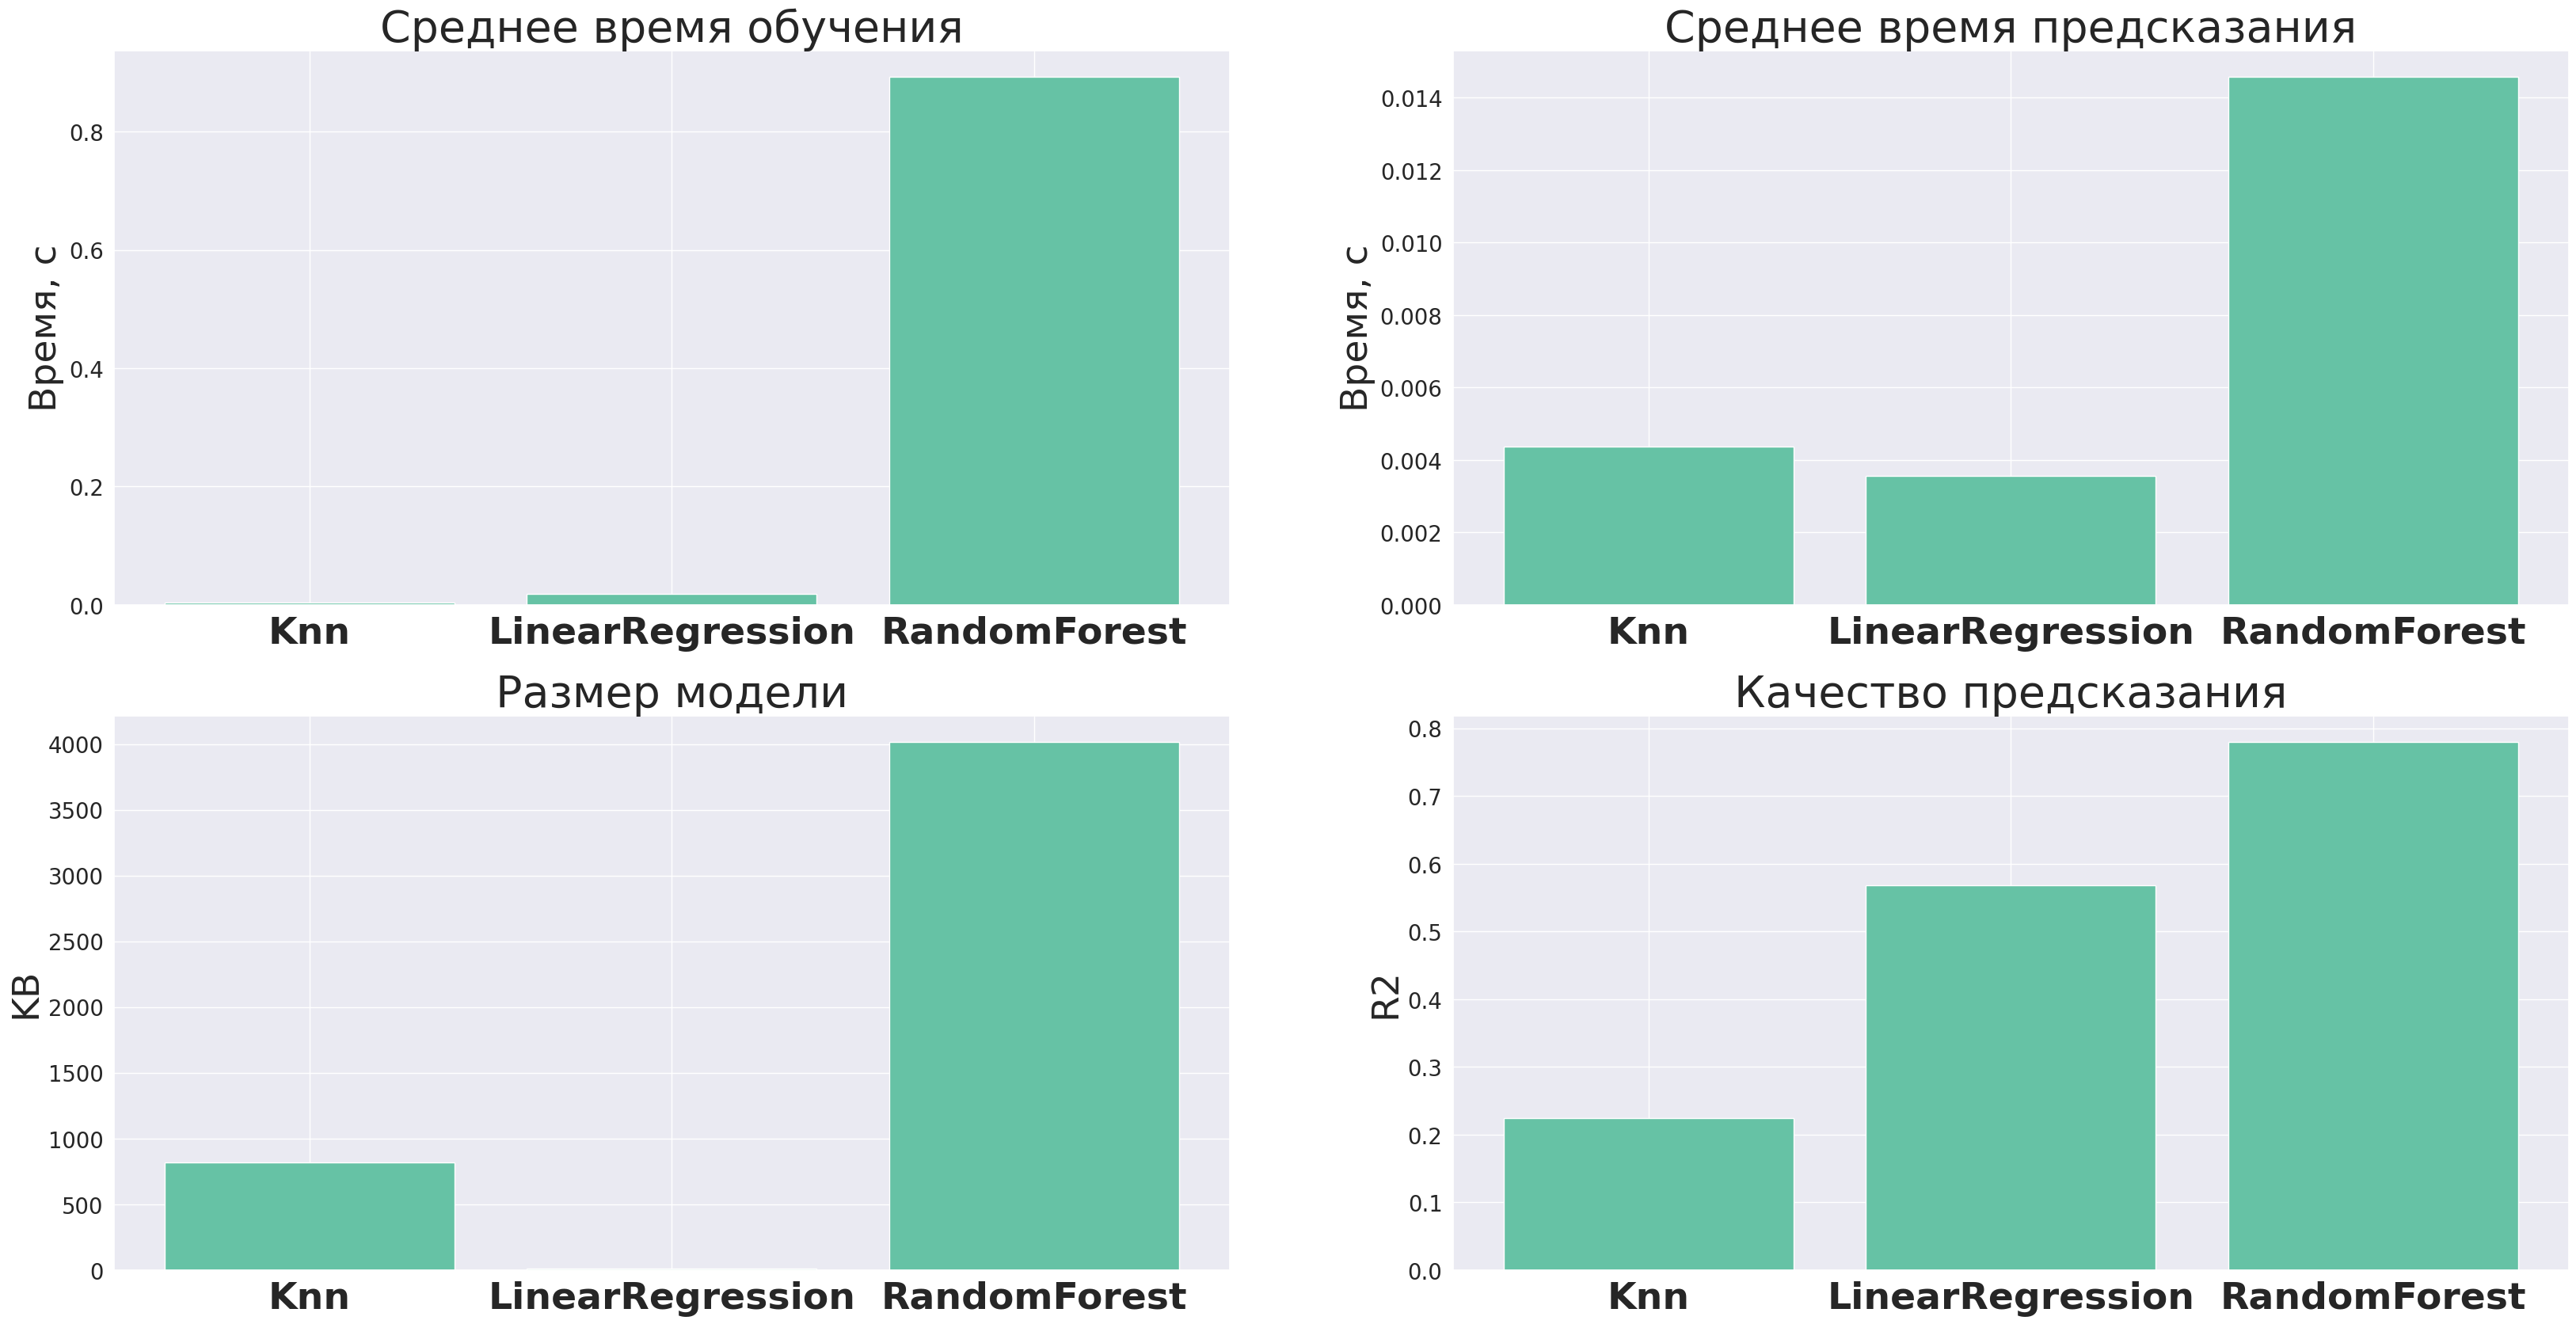

In [18]:
models = [KNeighborsRegressor(), LinearRegression(), RandomForestRegressor(n_jobs=1)]
labels = ["Knn", "LinearRegression", "RandomForest"]
colors = ["#66c2a5", "#66c2a5", "#66c2a5"]

plot_compare_model_performance(
    models, X_train_encoded, X_test_encoded, y_train, y_test, labels, colors
)

Как видим, модель случайного леса дает наивысшие качество, при этом проигрывает по другим характеристикам.

## 3. Сравнение леса и бустинга на синтетических данных




### 3.1 Обучение градиентного бустинга для регрессии

Посмотрим в деталях как обучается бустинг. Для этого проведем эксперимент на синтетических данных. Будем решать задачу регрессии.

Посмотрим на данные

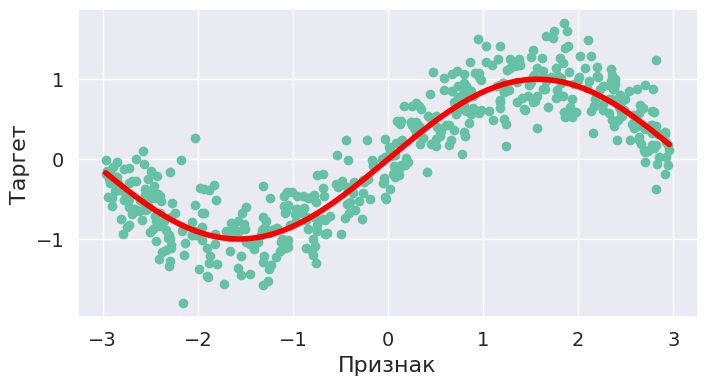

In [19]:
X_train = scipy.stats.uniform.rvs(loc=-3, scale=6, size=(500, 1), random_state=RANDOM_STATE)
grid = np.linspace(X_train.min(), X_train.max(), 500).reshape(-1, 1)
y_train = np.ravel(np.sin(X_train)) + scipy.stats.norm.rvs(
    scale=0.3, size=500, random_state=RANDOM_STATE
)
X_test = scipy.stats.uniform.rvs(loc=-3, scale=6, size=(100, 1), random_state=RANDOM_STATE)
y_test = np.ravel(np.sin(X_test)) + scipy.stats.norm.rvs(
    scale=0.3, size=100, random_state=RANDOM_STATE
)


plt.figure(figsize=(8, 4))
plt.scatter(X_train, y_train)
plt.plot(grid, np.ravel(np.sin(grid)), c="red", linewidth=4)
plt.xlabel("Признак", fontsize=16)
plt.ylabel("Таргет", fontsize=16)
plt.tick_params(labelsize=14)

plt.show()

Посмотрим как с этой задачей справится модель градиентного бустинга.

Градиентный бустинг — это ансамблевый метод, который последовательно строит деревья, каждое из которых исправляет ошибки предыдущих. Для задачи регрессии алгоритм минимизирует квадратичную или другую дифференцируемую функцию потерь.

- 1. Инициализация модели

Стартуем от начального предсказания:

$$
b_0(x) = \arg\min_{\gamma} \sum_{i=1}^n \mathcal{L}(Y_i, \gamma)
$$

Для квадратичной потери $\mathcal{L}(y,z) = \frac{1}{2}(y - z)^2$ это просто среднее:

$$
b_0(x) = \frac{1}{n} \sum_{i=1}^n Y_i
$$


Полагаем начальную модель:

$$
\hat{y}_0(x) = b_0(x)
$$


- 2. Итеративное обучение (для шагов m = 1 до M)

а) Вычисление остатков.
Для каждого объекта вычисляем отрицательный градиент функции потерь:

$$
\widetilde{g}^t = \left( \nabla_s \mathcal{L}(Y_i, s) \bigg|_{s=\hat{y}_{t-1}(x_i)} \right)_{i=1}^n
$$


Для квадратичной потери остатки равны:
$$
\widetilde{g}_i^t = Y_i - \hat{y}_{t-1}(x_i)
$$


 б) Обучение дерева на остатках.


Обучаем дерево $b_t(x)$ предсказывать значения $-\widetilde{g}_i^t$ (антиградиент):

$$
b_t(x) = \arg\min_{b \in \mathcal{F}} \sum_{i=1}^n \left( b(x_i) + \widetilde{g}_i^t \right)^2
$$

в) Оптимизация веса листьев.
Для каждого листа $ j $ дерева находим оптимальное значение, минимизирующее потери:

$$
\widetilde{\gamma}_{t} = \arg\min_{\gamma \in \mathbb{R}} \sum_{i=1} L(Y_i, \widehat{y}_{t-1}(x_i) + \gamma b_t(x_i))
$$


 г) Обновление модели.
Добавляем новое дерево с коэффициентом обучения $\eta $:

$$
\widehat{y}_t(x) = \widehat{y}_{t-1}(x) + \eta \cdot \widetilde{\gamma}_{t} \cdot b_t(x)
$$

где $ \eta $ — скорость обучения (обычно 0.01-0.1).

- 3. Итоговая модель

После $T$ итераций финальный предсказатель:
$$
\widehat{y}_T(x) = \sum_{t=0}^T \gamma_t b_t(x)
$$

In [20]:
regressor = GradientBoostingRegressor(learning_rate=1, n_estimators=100, max_depth=3)
regressor.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=1)

У бустинга есть метод `staged_predict`. Он выдает предсказания композиции первых $t$ моделей бустинга. Используя этот метод, нарисуем для каждого  
$t$ два графика:
- График предсказаний первых  $t$ моделей и истинных ответов;
- График ошибки на шаге $t$ и предсказаний $t$-й компоненты бустинга.

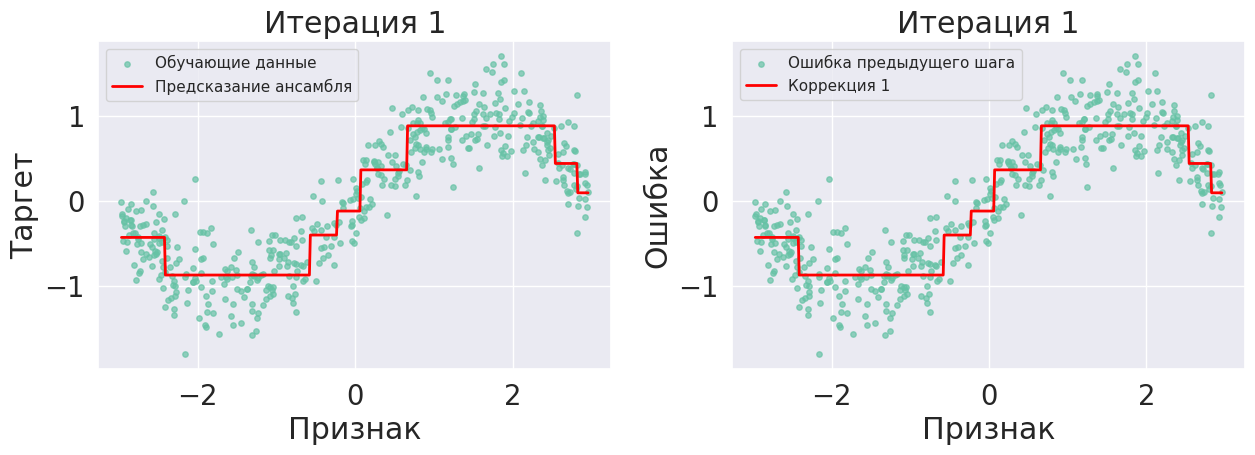

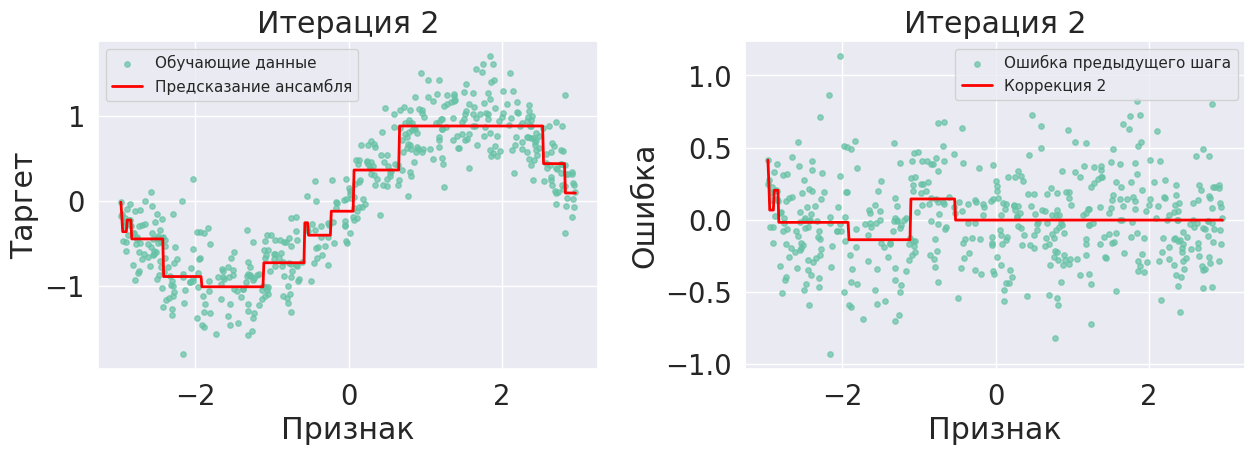

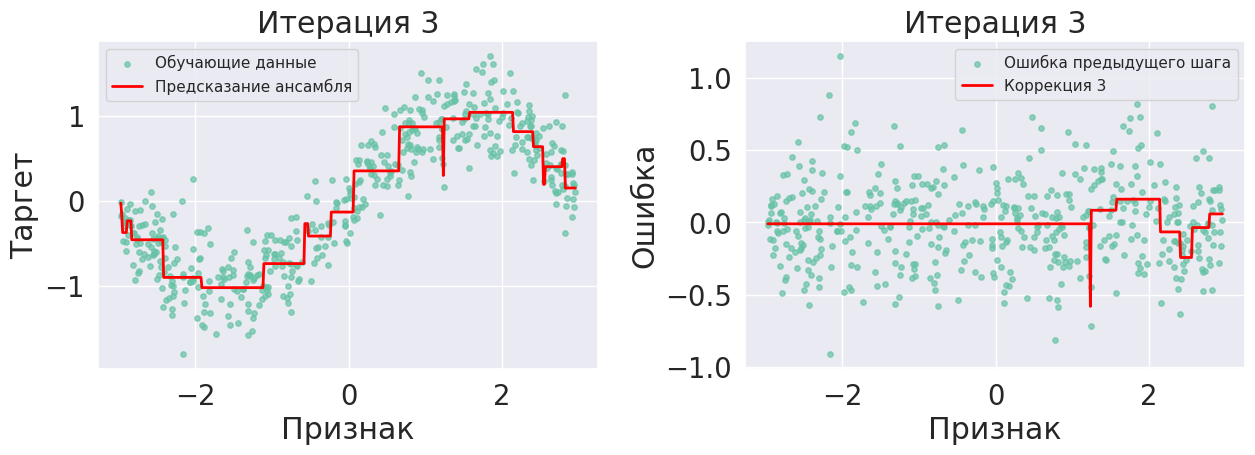

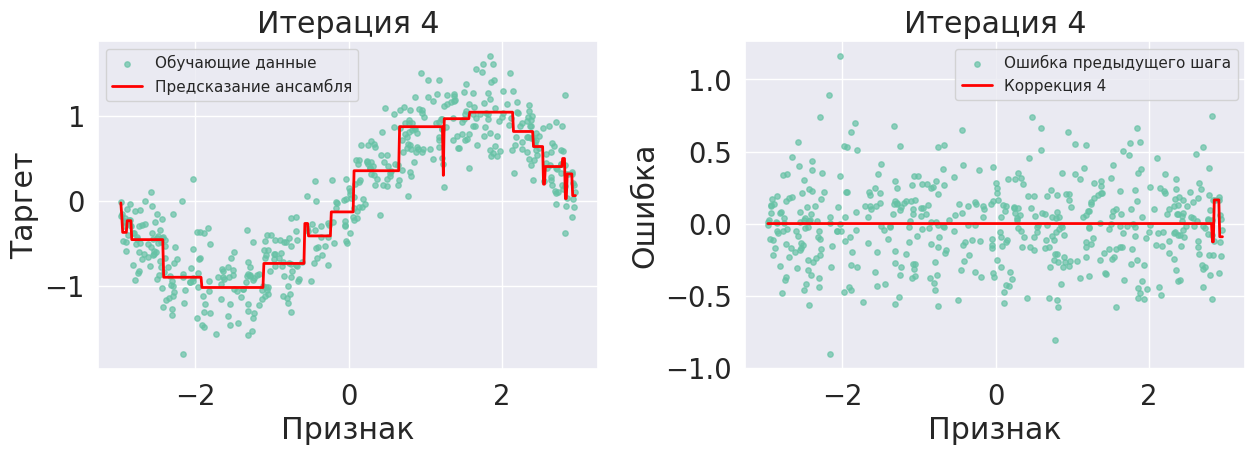

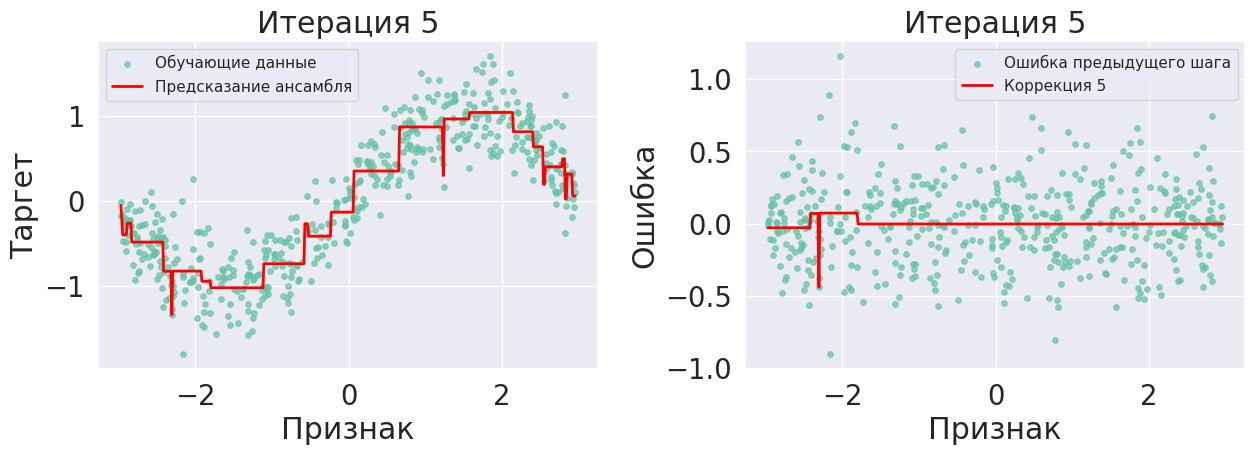

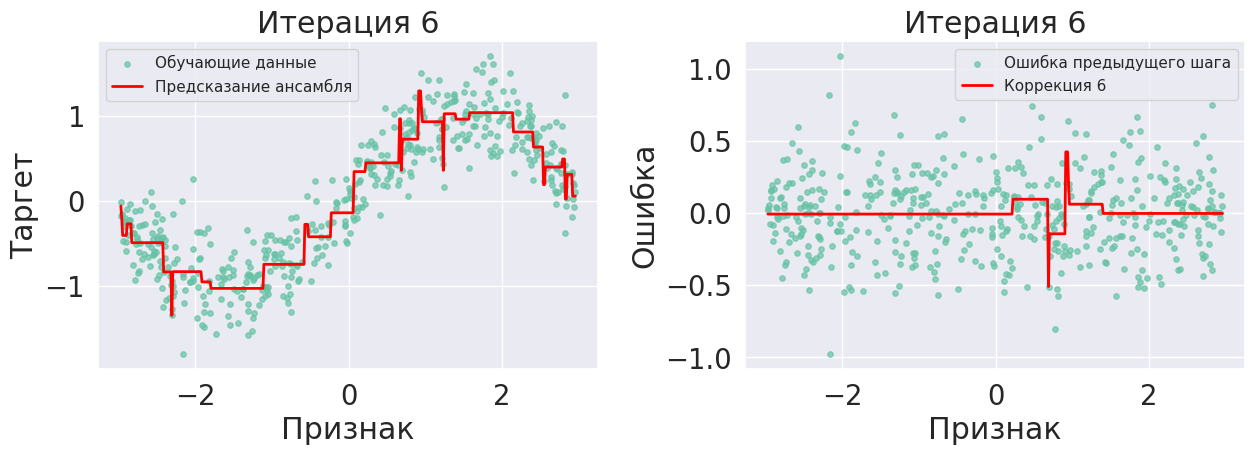

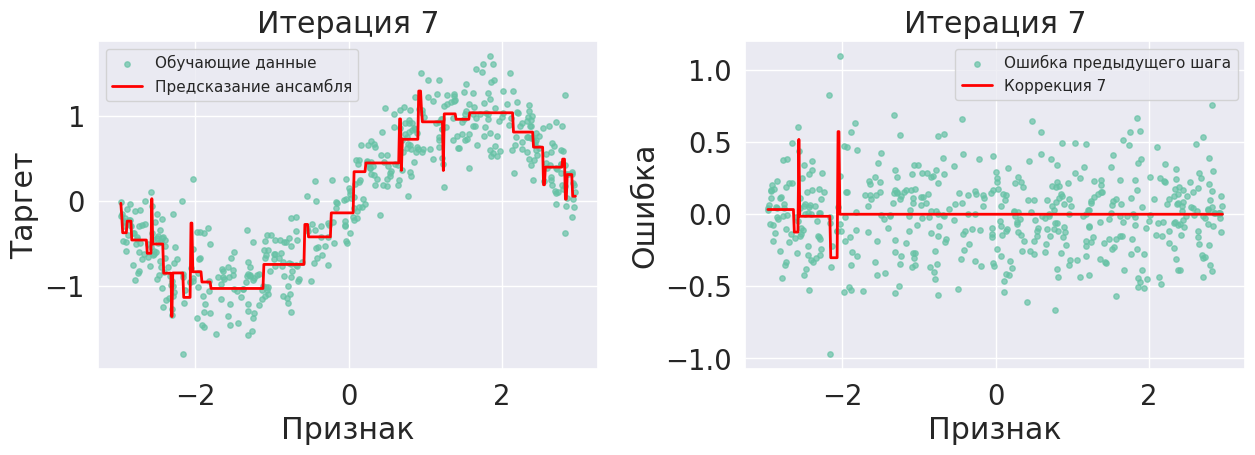

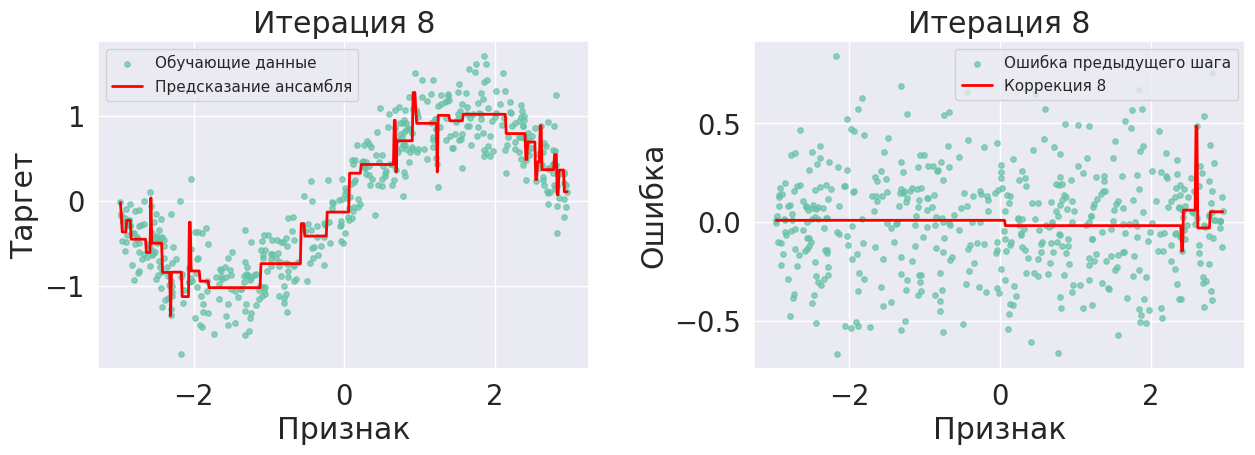

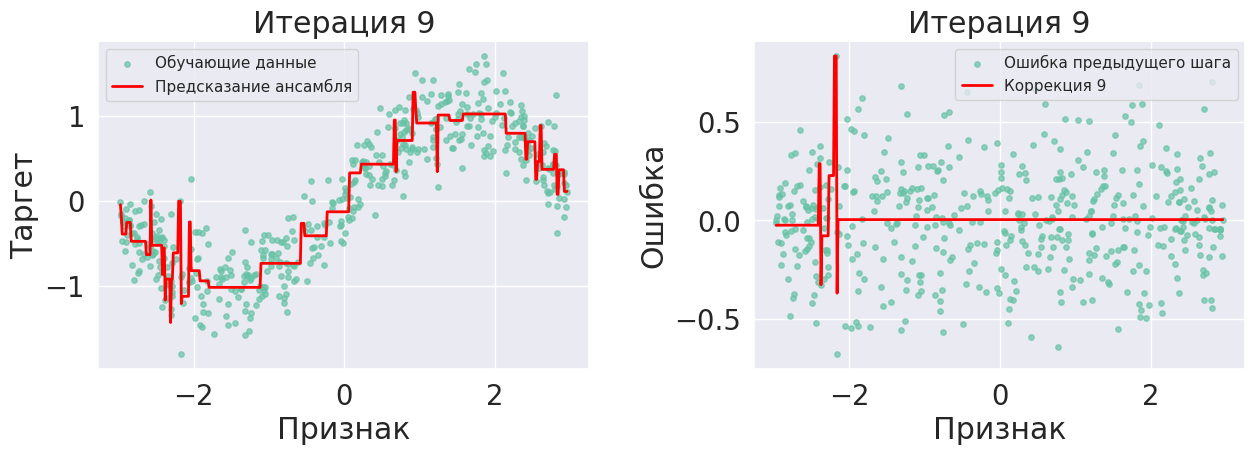

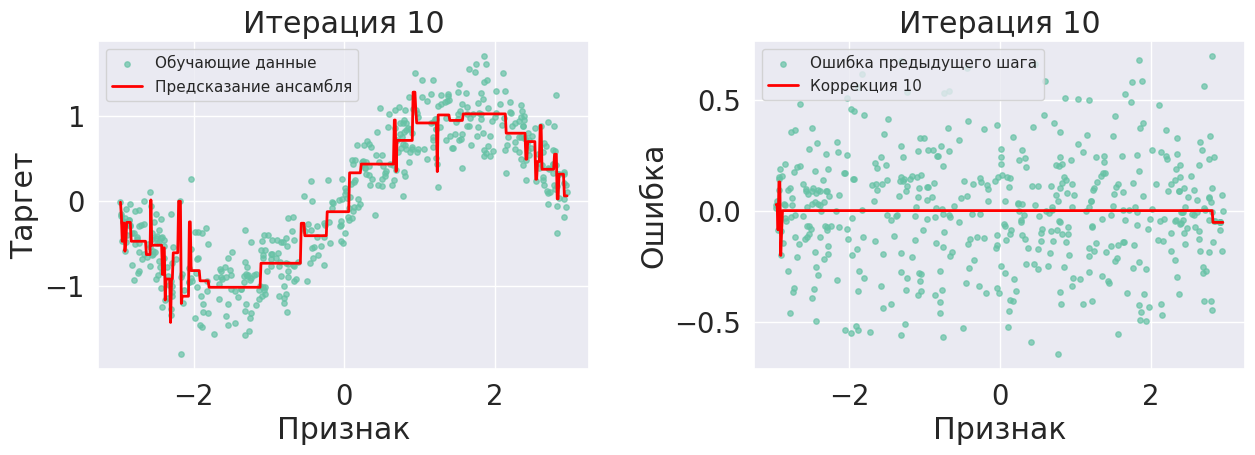

In [21]:
staged = list(regressor.staged_predict(X_train))
staged_grid = list(regressor.staged_predict(grid))

for i in range(10):
    if i == 0:
        previous_predict = 0
    else:
        previous_predict = staged[i - 1]

    error = y_train - previous_predict

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

    # Первый график
    scatter1 = ax1.scatter(X_train, y_train, label="Обучающие данные", s=15, alpha=0.7)
    (line1,) = ax1.plot(
        grid, staged_grid[i], color="red", linewidth=2, label="Предсказание ансамбля"
    )
    ax1.set_xlabel("Признак")
    ax1.set_ylabel("Таргет")
    ax1.set_title(f"Итерация {i+1}")
    ax1.legend(fontsize=11, loc="best")

    # Второй график
    scatter2 = ax2.scatter(X_train, error, label="Ошибка предыдущего шага", s=15, alpha=0.7)
    (line2,) = ax2.plot(
        grid,
        staged_grid[i] - (i > 0) * staged_grid[i - 1],
        color="red",
        linewidth=2,
        label=f"Коррекция {i+1}",
    )
    ax2.set_xlabel("Признак")
    ax2.set_ylabel("Ошибка")
    ax2.set_title(f"Итерация {i+1}")
    ax2.legend(fontsize=11, loc="best")

    plt.tight_layout()
    plt.show()

### 3.2 Зависимость качества от числа деревевьев

Проведем аналогичный эксперемент, но для куда большего числа деревьев.


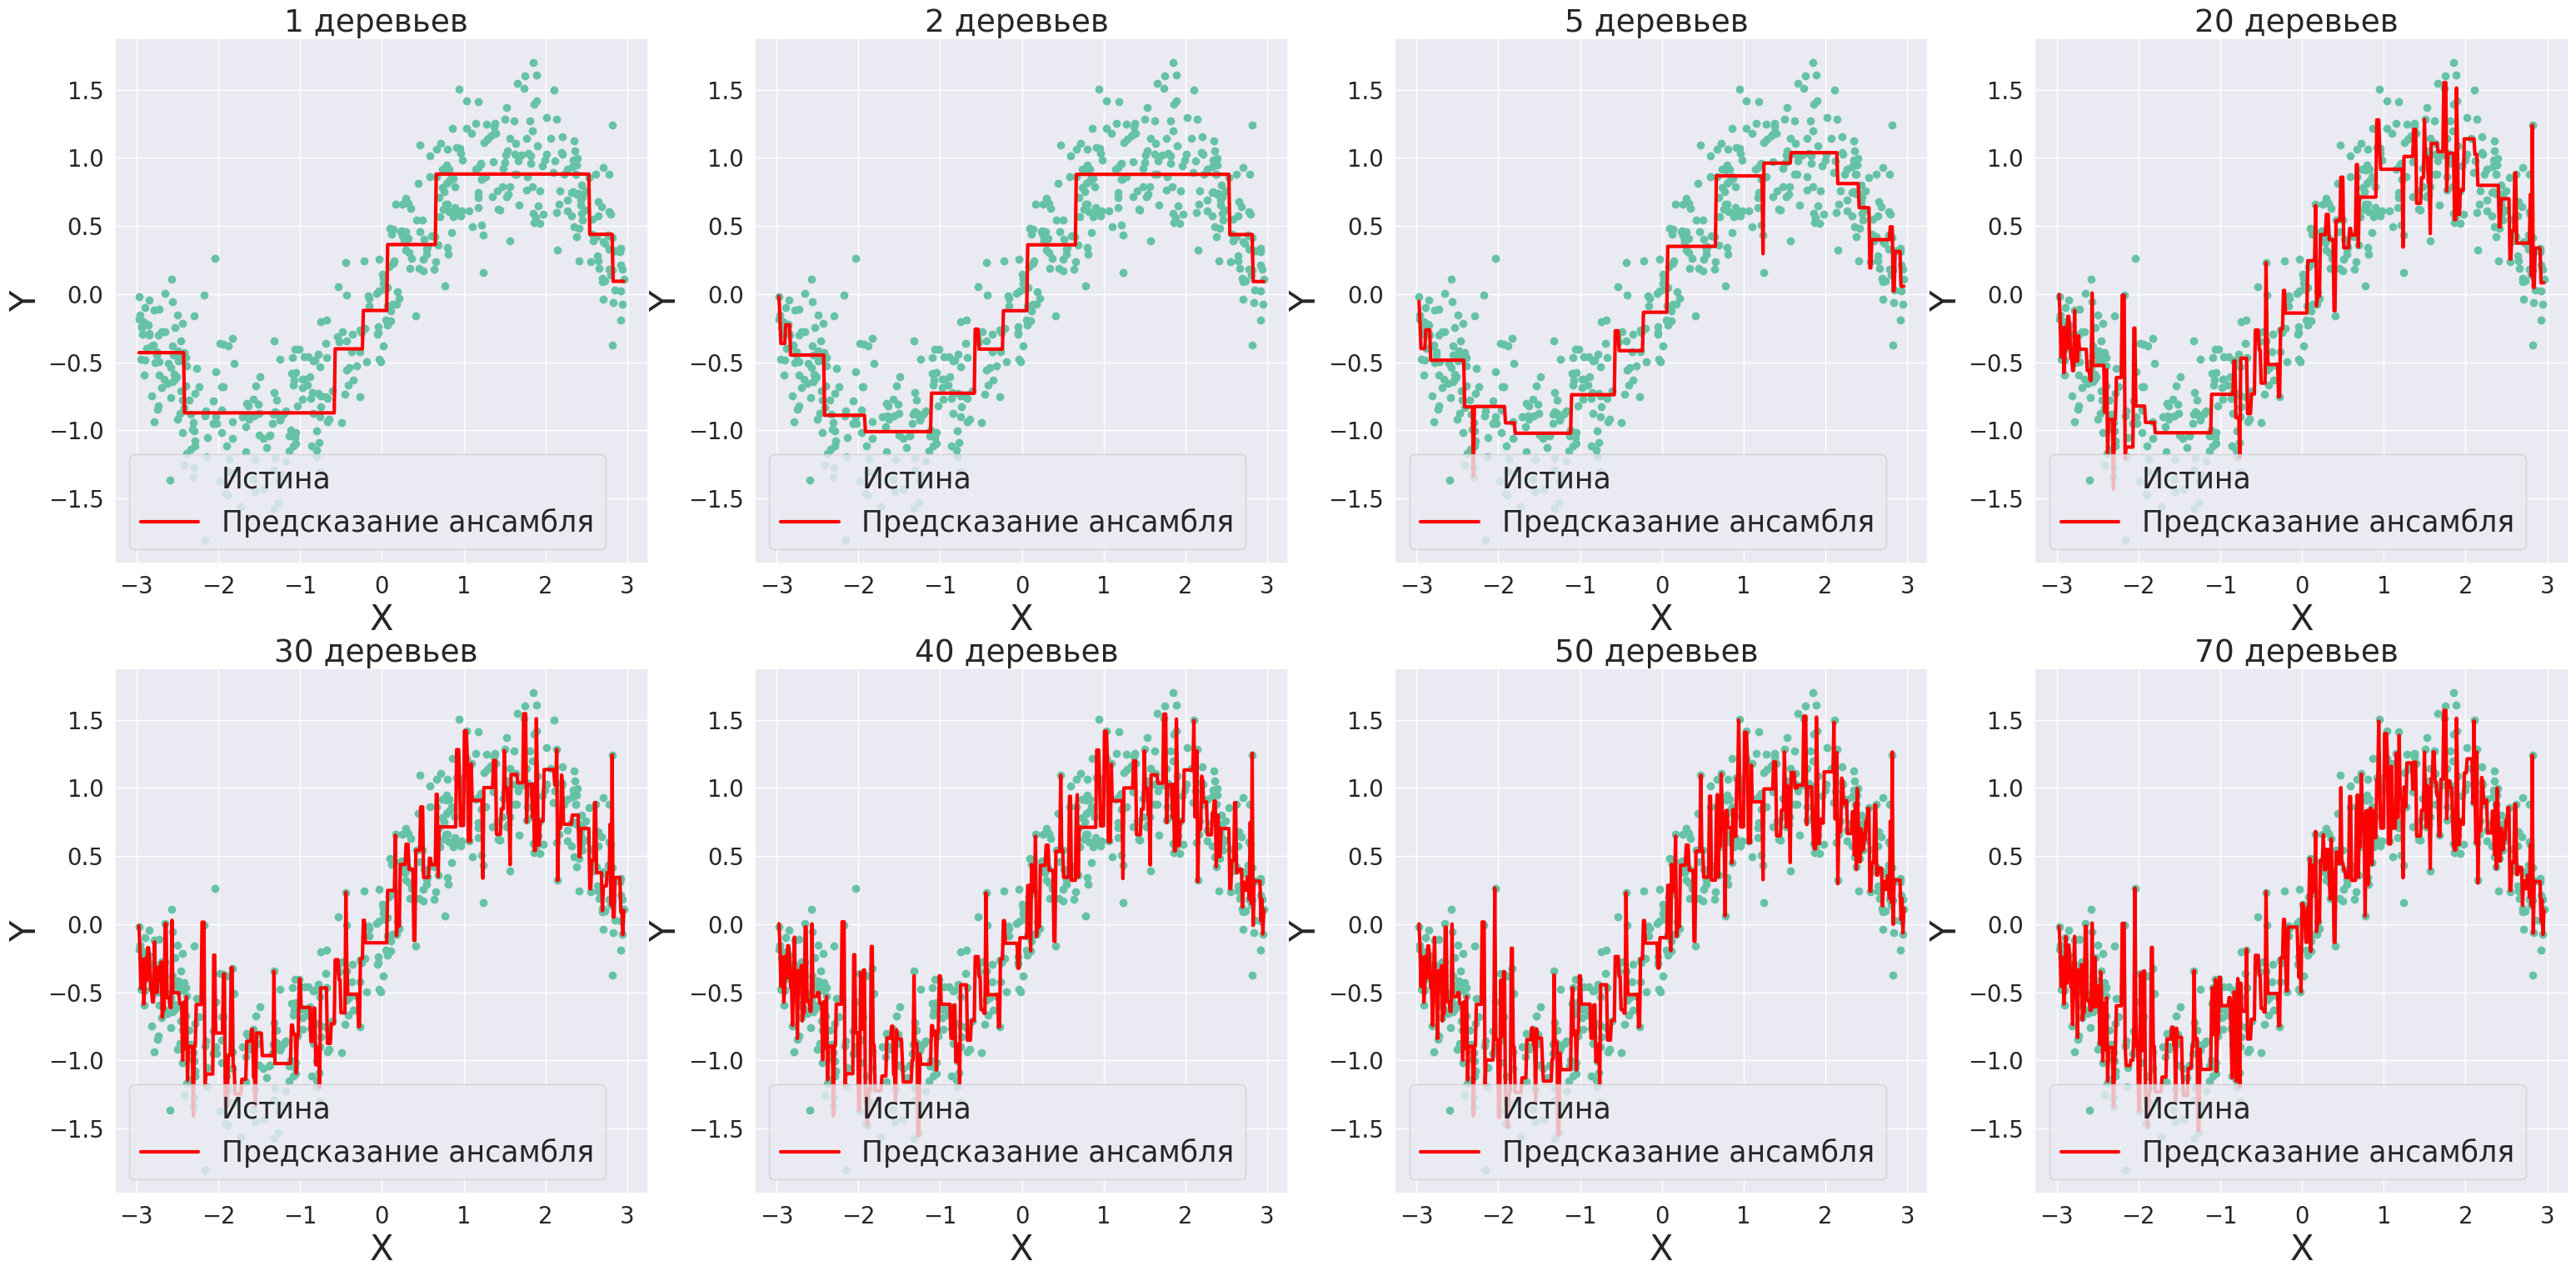

In [22]:
plt.figure(figsize=(38, 18))
sizes = [1, 2, 5, 20, 30, 40, 50, 70]
for i, s in enumerate(sizes):

    plt.subplot(2, 4, i + 1)
    plt.scatter(X_train, y_train, label="Истина")
    plt.plot(grid, staged_grid[s - 1], color="red", linewidth=3, label="Предсказание ансамбля")
    plt.legend(fontsize=25)
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    plt.title(f"{s} деревьев ", fontsize=27)

&#x2753; **Вопрос** &#x2753;


> Почему при увеличении числа деревьев модель сильно переобучается?


<details>
 <summary> Кликни для показа ответа </summary>

 > Ответ

 Градиентный бустинг строит деревья последовательно, каждое новое дерево корректирует ошибки предыдущих. Если деревьев слишком много, модель начинает "подстраиваться" под шум в данных, а не только под полезные закономерности.
</details><br/>


Посмотрим на то как в аналогичном эксперименте  поведет себя случайный лес.

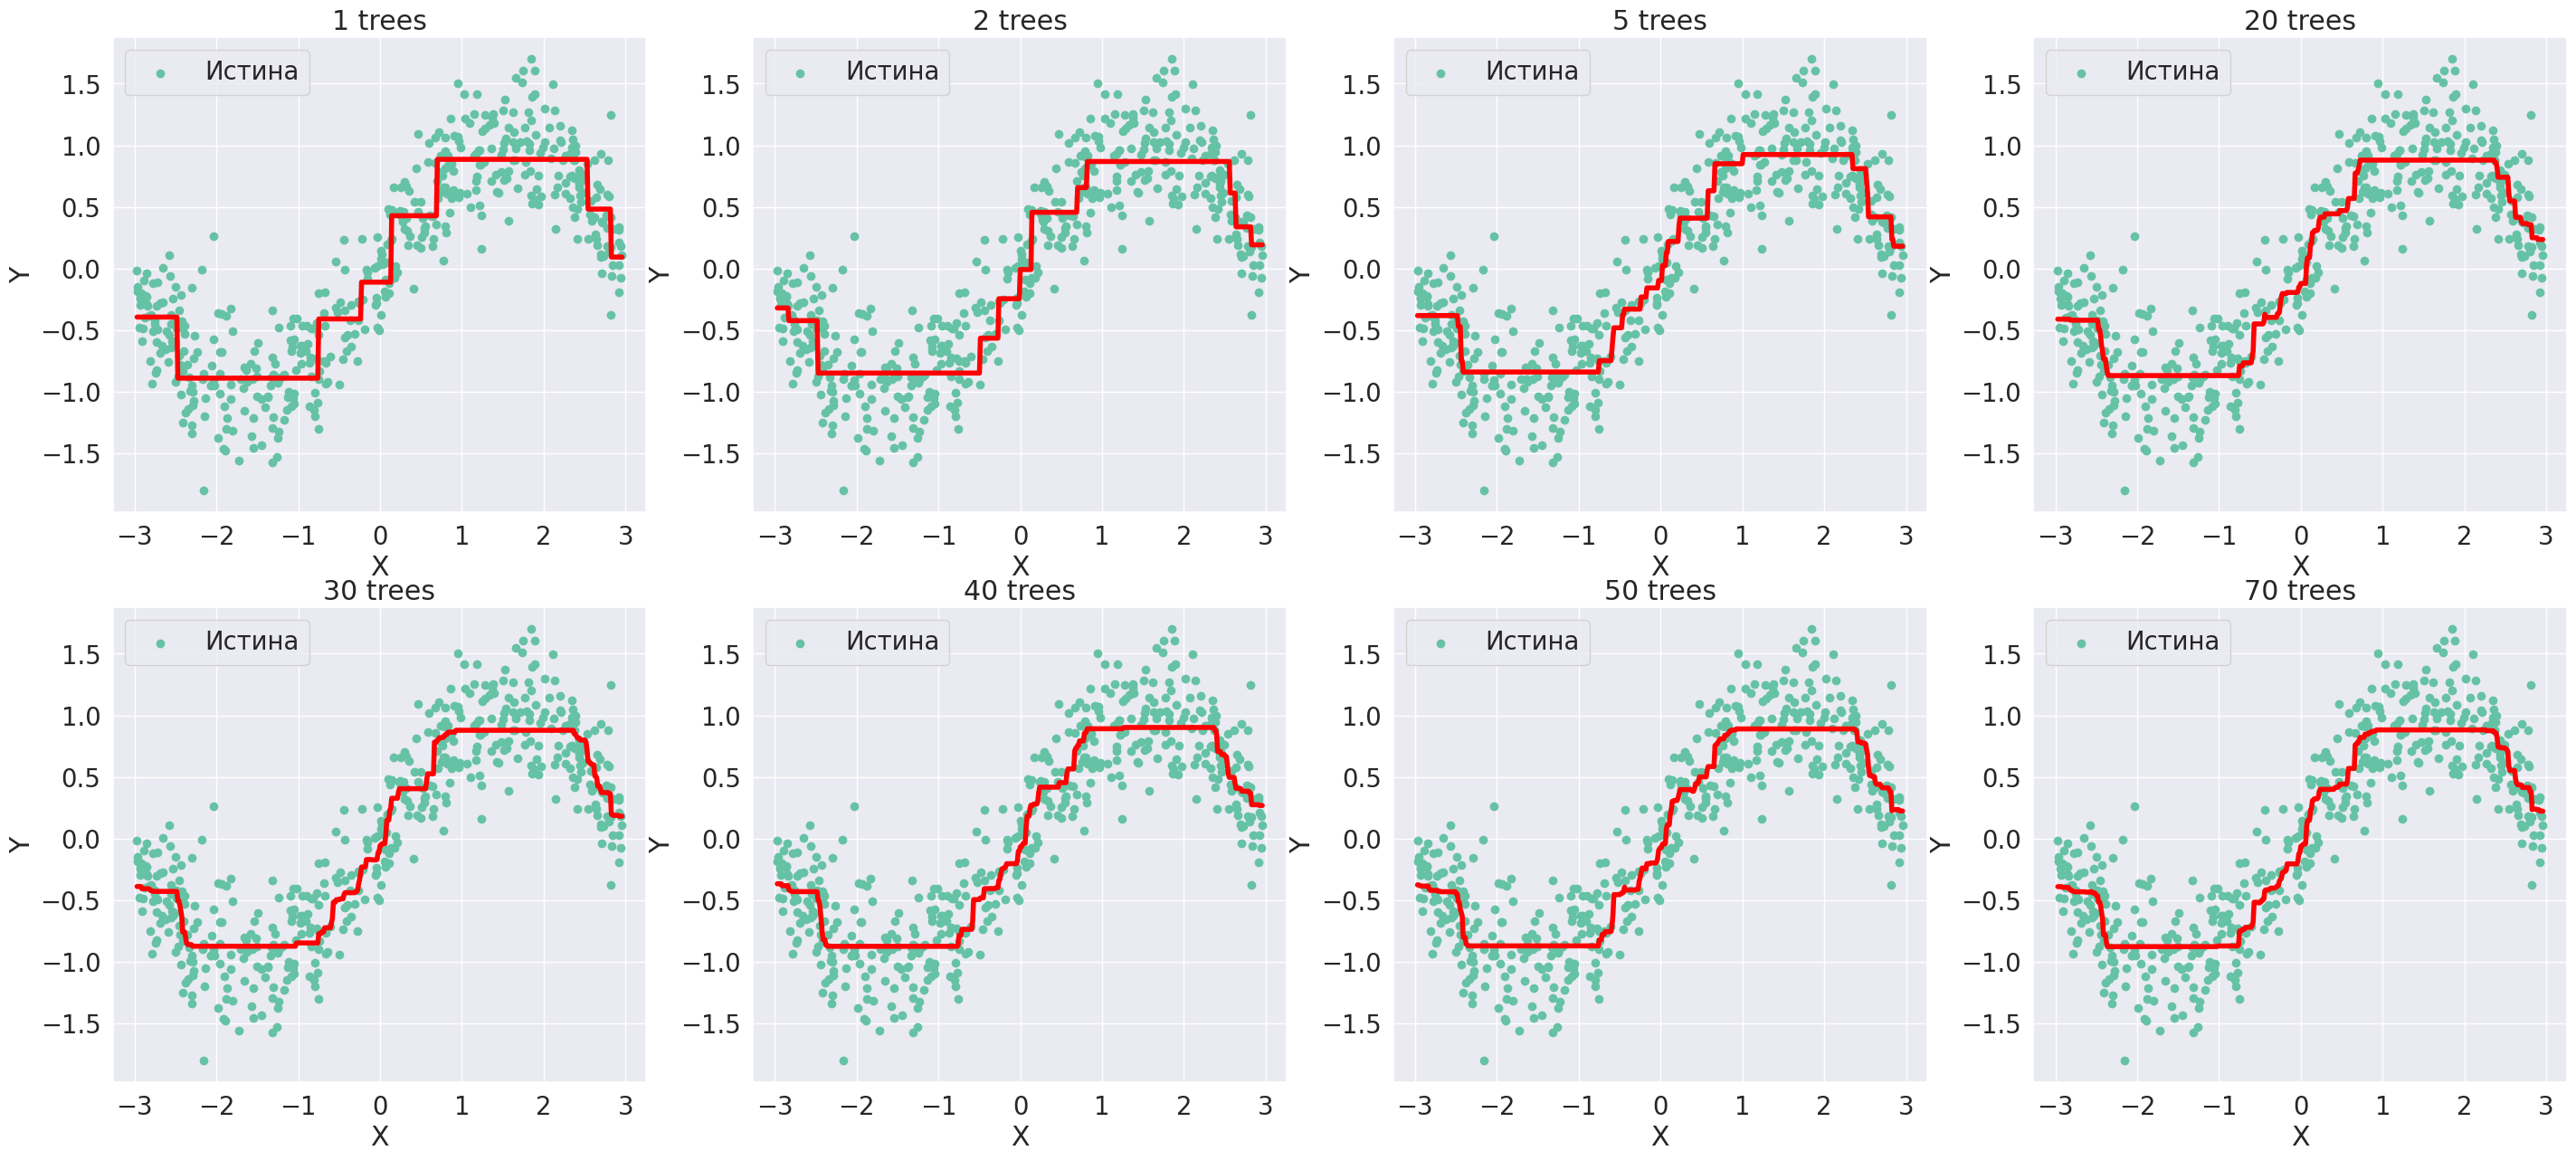

In [23]:
reg = RandomForestRegressor(max_depth=3)
plt.figure(figsize=(35, 15))

for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train, y_train)
    plt.subplot(2, 4, i + 1)
    plt.scatter(X_train, y_train, label="Истина")
    plt.legend()
    plt.xlabel("X")
    plt.ylabel("Y")

    plt.plot(grid, reg.predict(grid), c="red", linewidth=4)
    plt.title("{} trees".format(s))


&#x2753; **Вопрос** &#x2753;


> Почему с ростом числа деревьев после определенного момента предсказания модели не особо меняются?


<details>
 <summary> Кликни для показа ответа </summary>

 >  Предсказание модели — это среднее предсказаний отдельных деревьев.По мере роста числа деревьев дисперсия предсказаний уменьшается, и модель выходит на предел обобщающей способности. Дальнейшее увеличение числа деревьев лишь немного снижает случайные колебания
</details><br/>


GBM склонен к переобучению из-за последовательного обучения и фокусировки на ошибках. В сравнении с ним, Random Forest более устойчив, благодаря случайности и усреднению. Но последовательная оптимизация ошибок дает GBM потенциальное преимущество в качестве. Чтобы этот потенциал реализовать, важно правильно подобрать гипермапаметры.

Например, попробуем изменить параметр `lerning rate` ($\eta$)

$$\widehat{y}_t(x) = \widehat{y}_{t-1}(x) + \eta \widetilde{\gamma}_t b_t(x)$$

Повтроим эксперимент, уменьшив `learning rate`.

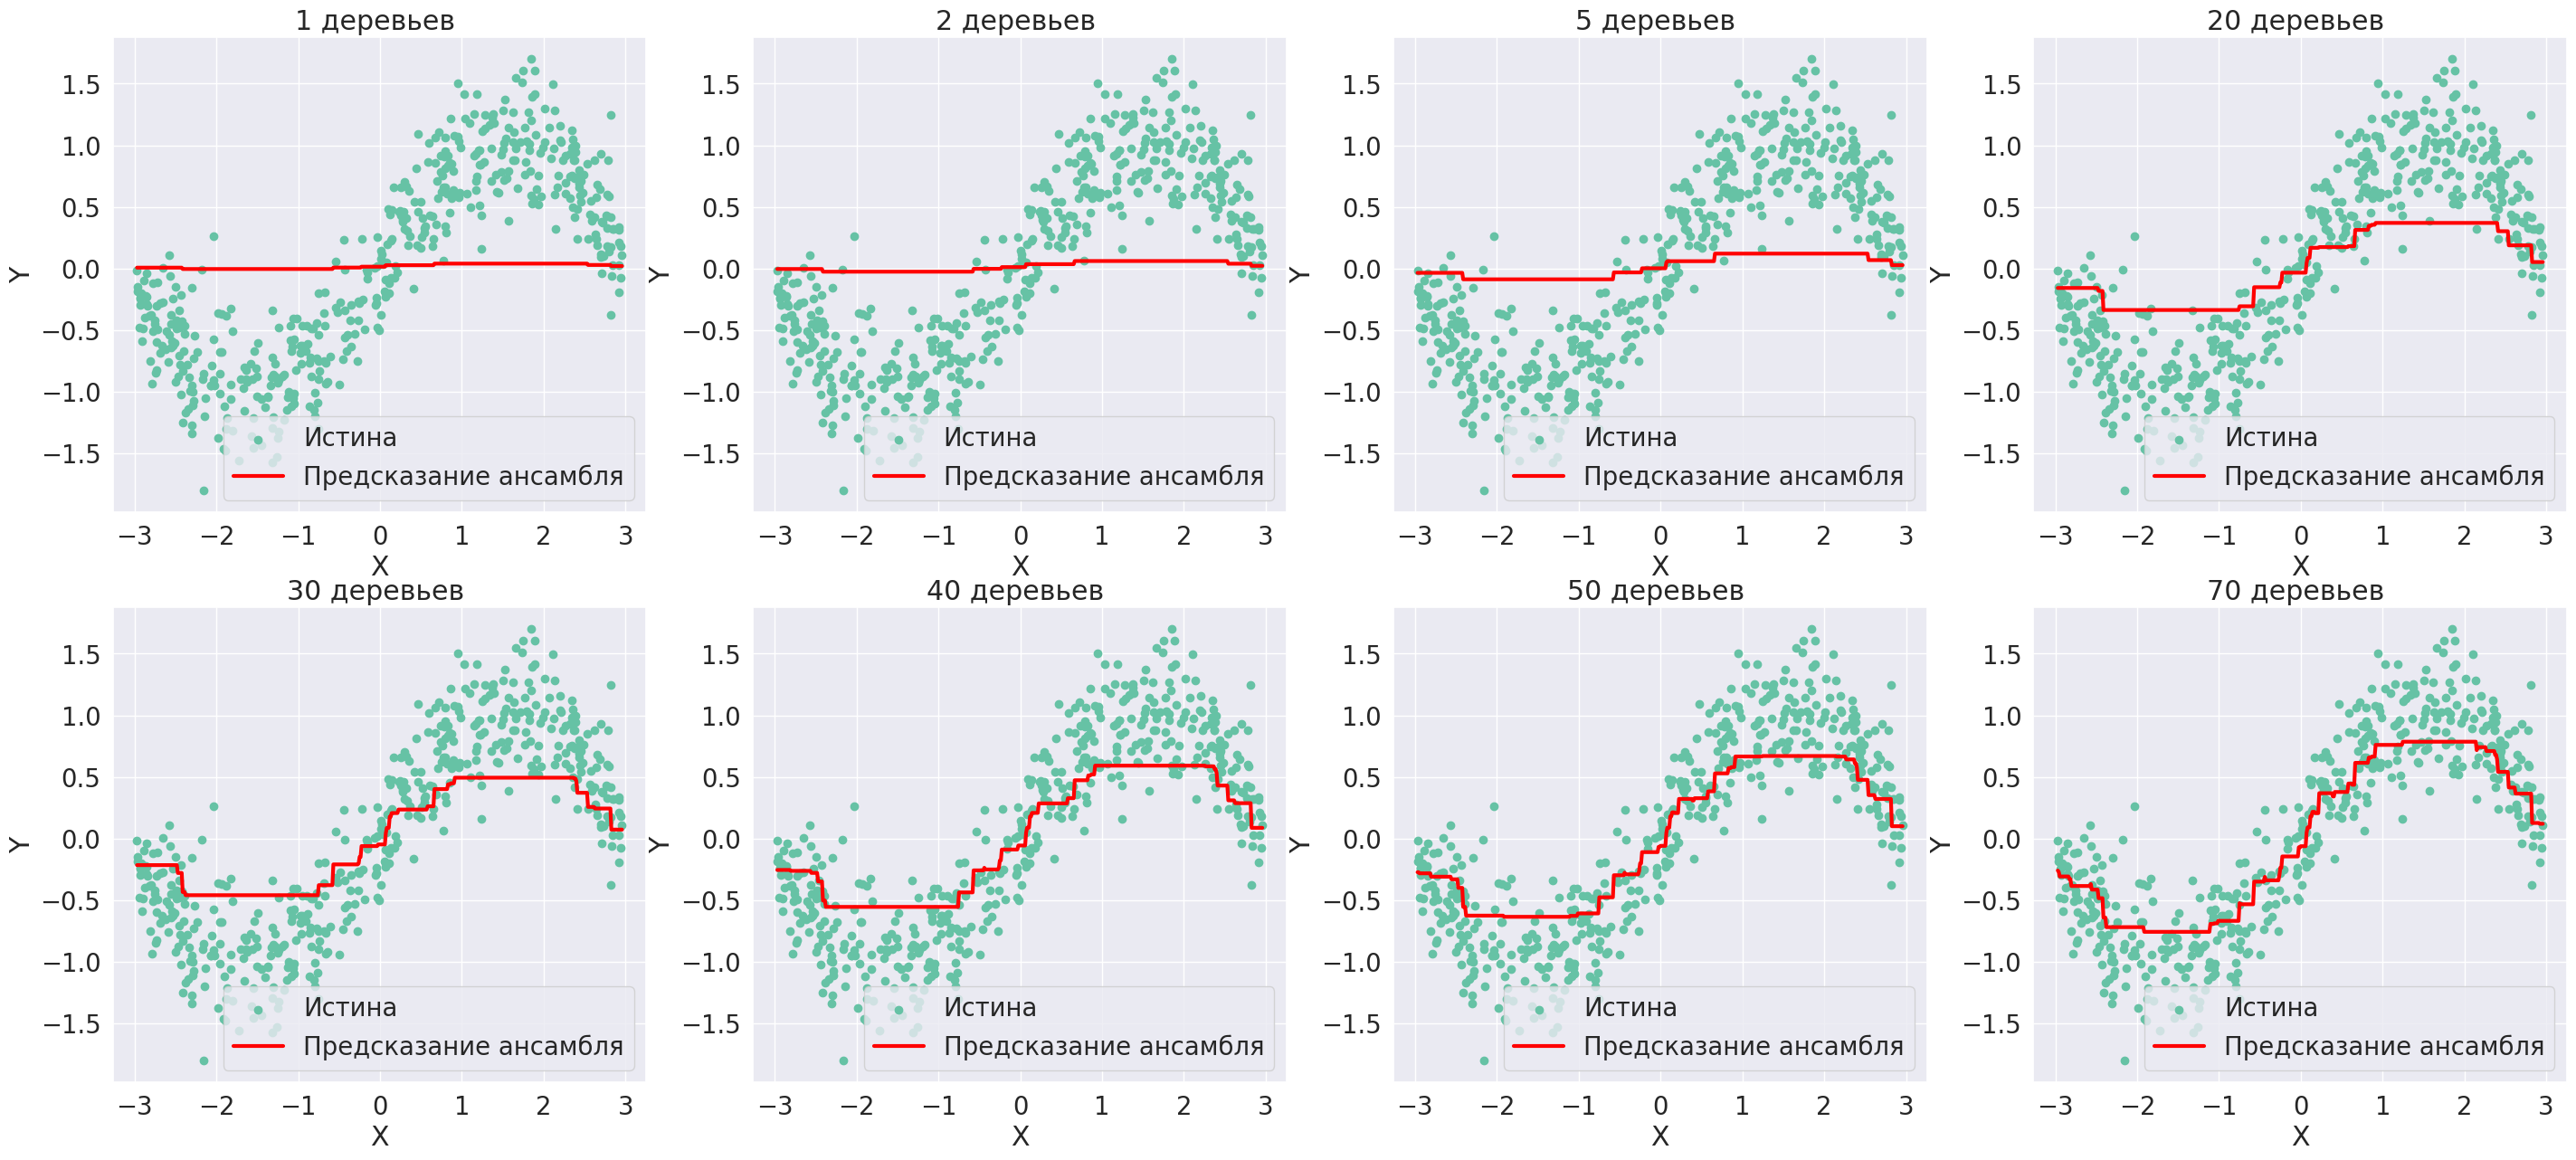

In [24]:
regressor = GradientBoostingRegressor(learning_rate=0.025, n_estimators=2000, max_depth=3)
regressor.fit(X_train, y_train)
staged = list(regressor.staged_predict(X_train))
staged_grid = list(regressor.staged_predict(grid))

plt.figure(figsize=(35, 15))
sizes = [1, 2, 5, 20, 30, 40, 50, 70]

for i, s in enumerate(sizes):

    plt.subplot(2, 4, i + 1)
    plt.scatter(X_train, y_train, label="Истина")
    plt.plot(grid, staged_grid[s - 1], color="red", linewidth=3, label="Предсказание ансамбля")
    plt.legend()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"{s} деревьев ")

Видим, что итоговый ансабль менее подвержен влиянию выбросов, но на определение исходной зависимости ему требуется куда большее число итераций.

### 3.3 Компоненты BV разложения


Посмотрим, как разное число деревьев влияет на компоненты Bais-variance разложения для градиентного бустинга.



В данной задаче мы будем работать со случайными векторами размерности **1x5** в качестве обучающий выборки. Сгенерируем вектора из многомерного нормального распределения.

**Таргетом** будет длина этого вектора.

Ниже функции для генерации:

In [25]:
def x_generate(sample_size: int) -> np.ndarray:
    return np.random.normal(size=(sample_size, 6), scale=2)


def dist_to_center(x: np.ndarray) -> np.ndarray:
    return np.sqrt((x**2).sum(axis=-1))


Будем проводить следующий эксперимент:

* `n_iter` раз генерировать выборку, обучать на ней одну и ту же `model` и на фиксированном контрольном объекте считать предсказание.

* Затем посмотрим среднее полученных предсказаний, а также построим по ним kde.

* Повторим эту процедуру для нескольких моделей и сравним результаты.

Тогда результат для одной модели будет выглядить следующим образом:

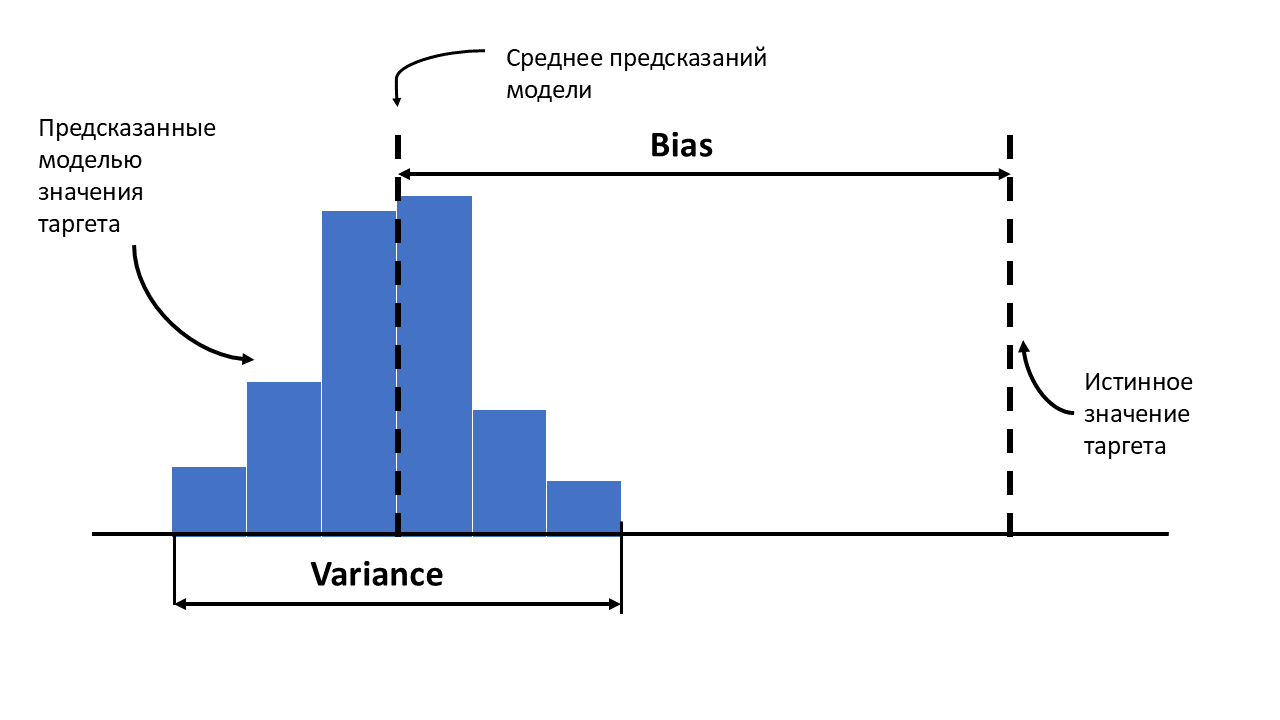

**Bias** мы можем оценить как разность между средним по всем предсказаниям и истиным значением таргета. А **Variance** как дисперсию распределения предсказаний модели.
Введем функцию для отрисовки предсказаний модели.

In [26]:
rng = np.random.default_rng()


def train_model_multiple_times(
    model: Any,
    x_generator: Callable[[int], np.ndarray],
    y: Callable[[np.ndarray], np.ndarray],
    n_iter: int = 500,
    sample_size: int = 500,
    example_point: np.ndarray = None,
) -> tuple[np.ndarray, float]:
    """
    Функция применяет модель n_iter раз к данным и возвращает предсказания.

    * model - модель
    * x_generator - функция генерирующая выборку
    * y - функция подсчета таргета
    * n_iter - количество применений
    * sample_size - размер выборки
    * example_point - точка для предсказания

    Returns:
    * Y_pred - массив предсказаний
    * Y_true - истинное значение
    """

    if example_point is None:
        example_point = [[1, 2, 3, 4, 5, 6]]

    Y_pred = []

    for i in trange(n_iter):
        x_train = x_generator(sample_size)
        y_train = y(x_train) + sps.norm(scale=1).rvs([sample_size])
        fitted = model.fit(x_train, y_train)
        Y_pred.append(fitted.predict(example_point)[0])

    Y_true = y(np.asarray(example_point))[0]

    return np.array(Y_pred), Y_true


def draw_predictions(
    model: Any,
    x_generator: Callable[[int], np.ndarray],
    y: Callable[[np.ndarray], np.ndarray],
    label: str,
    n_iter: int = 500,
    log: bool = True,
    show: bool = True,
    sample_size: int = 500,
    color: str = "blue",
    xlim: tuple[float, float] = (-100, 100),
    new_figure: bool = True,
    title: str = "",
) -> None:
    """
    Функция рисует kde предсказаний и выводит статистики.

    * Y_pred - массив предсказаний
    * Y_true - истинное значение
    * label - label кривой на графике
    * log - логирование статистик в stdout
    * show - будет ли вызван plt.show
    * color - цвет графика
    * xlim - пределы по x
    * new_figure - создавать новый график
    * title - заголовок графика
    * model - модель (для логирования)
    """
    Y_pred, Y_true = train_model_multiple_times(
        model=model, x_generator=x_generator, y=y, n_iter=n_iter, sample_size=sample_size
    )

    if new_figure:
        plt.figure(figsize=(12, 5))

    # Рисуем KDE предсказаний
    sns.kdeplot(Y_pred, fill=True, color=color, label="kde " + label, alpha=0.35, linewidth=0)

    # Отмечаем среднее значение предсказаний
    plt.plot([np.mean(Y_pred)], [0], marker="^", ms=20, color=color)

    # Отмечаем истинное значение
    if show:
        plt.axvline([Y_true], color="red", label="$y(x)$")

    plt.title(title, fontsize=18)
    plt.xlabel("Область значений модели")
    plt.xlim(xlim)
    plt.legend(fontsize=12)

    if show:
        plt.legend(loc="best")
        plt.show()

    if log:
        print("model =", model if model else "Не указана")
        print("x_new = [1, 2, 3, 4, 5, 6]")
        print("Var(x_new.T @ theta) =", np.var(Y_pred))
        print("bias(x_new.T @ theta) =", np.mean(Y_pred) - Y_true)
        print("MSE =", np.mean((Y_pred - Y_true) ** 2))

Сраним модели градиентного бустинга с параметром числа деревьев `n_estimators` = 1, 10 , 50 и 100

100%|██████████| 500/500 [02:03<00:00,  4.03it/s]


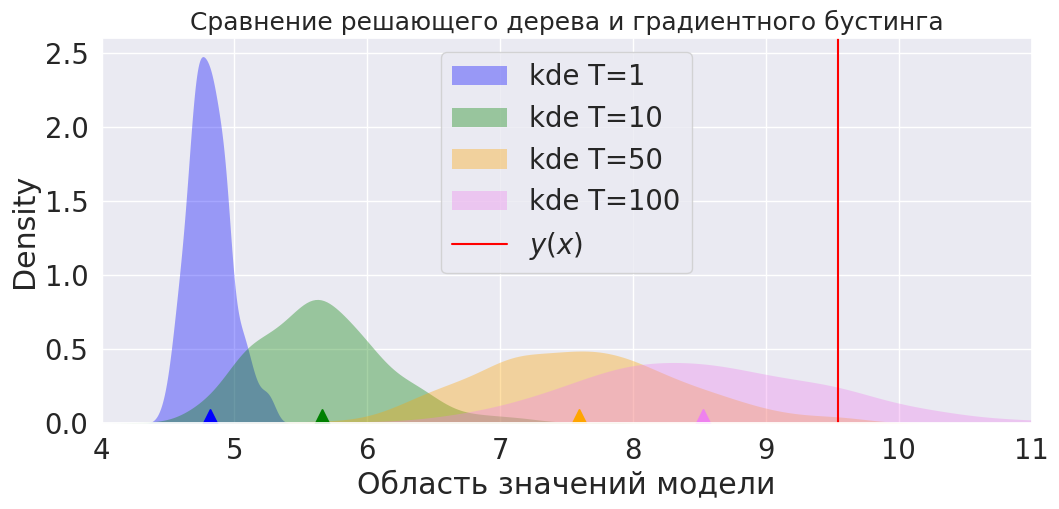

In [27]:
draw_predictions(
    GradientBoostingRegressor(n_estimators=1),
    x_generate,
    dist_to_center,
    "T=1",
    show=False,
    log=False,
)
draw_predictions(
    GradientBoostingRegressor(n_estimators=10),
    x_generate,
    dist_to_center,
    "T=10",
    show=False,
    log=False,
    color="green",
    new_figure=False,
)
draw_predictions(
    GradientBoostingRegressor(n_estimators=50),
    x_generate,
    dist_to_center,
    "T=50",
    show=False,
    log=False,
    color="orange",
    new_figure=False,
)
draw_predictions(
    GradientBoostingRegressor(n_estimators=100),
    x_generate,
    dist_to_center,
    "T=100",
    show=True,
    log=False,
    color="violet",
    xlim=(4, 11),
    new_figure=False,
    title="Сравнение решающего дерева и градиентного бустинга",
)

Результаты:

* **Bias падает**: с ростом числа деревьев ансамбль все точнее аппроксимирует сложные зависимости в обучающих данных. Ошибка модели на тренировочном наборе стремится к нулю.

* **Variance растет**: на поздних шагах деревья начинают "запоминать" не закономерность, а шум в обучающих данных. Модель становится чрезмерно подстроенной под конкретный набор данных.

## 4. Скорости обучения и предсказания бустинга

Теперь, вооружившись новой моделью, вернемся к исходному датасету и
повторим оценку всех ключевых параметров модели, добавив к рассмотрению модель градиентного бустинга.

In [28]:
# Исходные данные (без кодирования)
X = salary_model.drop("avg_salary", axis=1)
y = salary_model["avg_salary"].values

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Получаем все возможные категории из тренировочного набора
train_dummies = pd.get_dummies(X_train)
test_dummies = pd.get_dummies(X_test)

# Синхронизируем столбцы (добавляем отсутствующие в test с нулями)
X_train_encoded = train_dummies
X_test_encoded = test_dummies.reindex(columns=train_dummies.columns, fill_value=0)

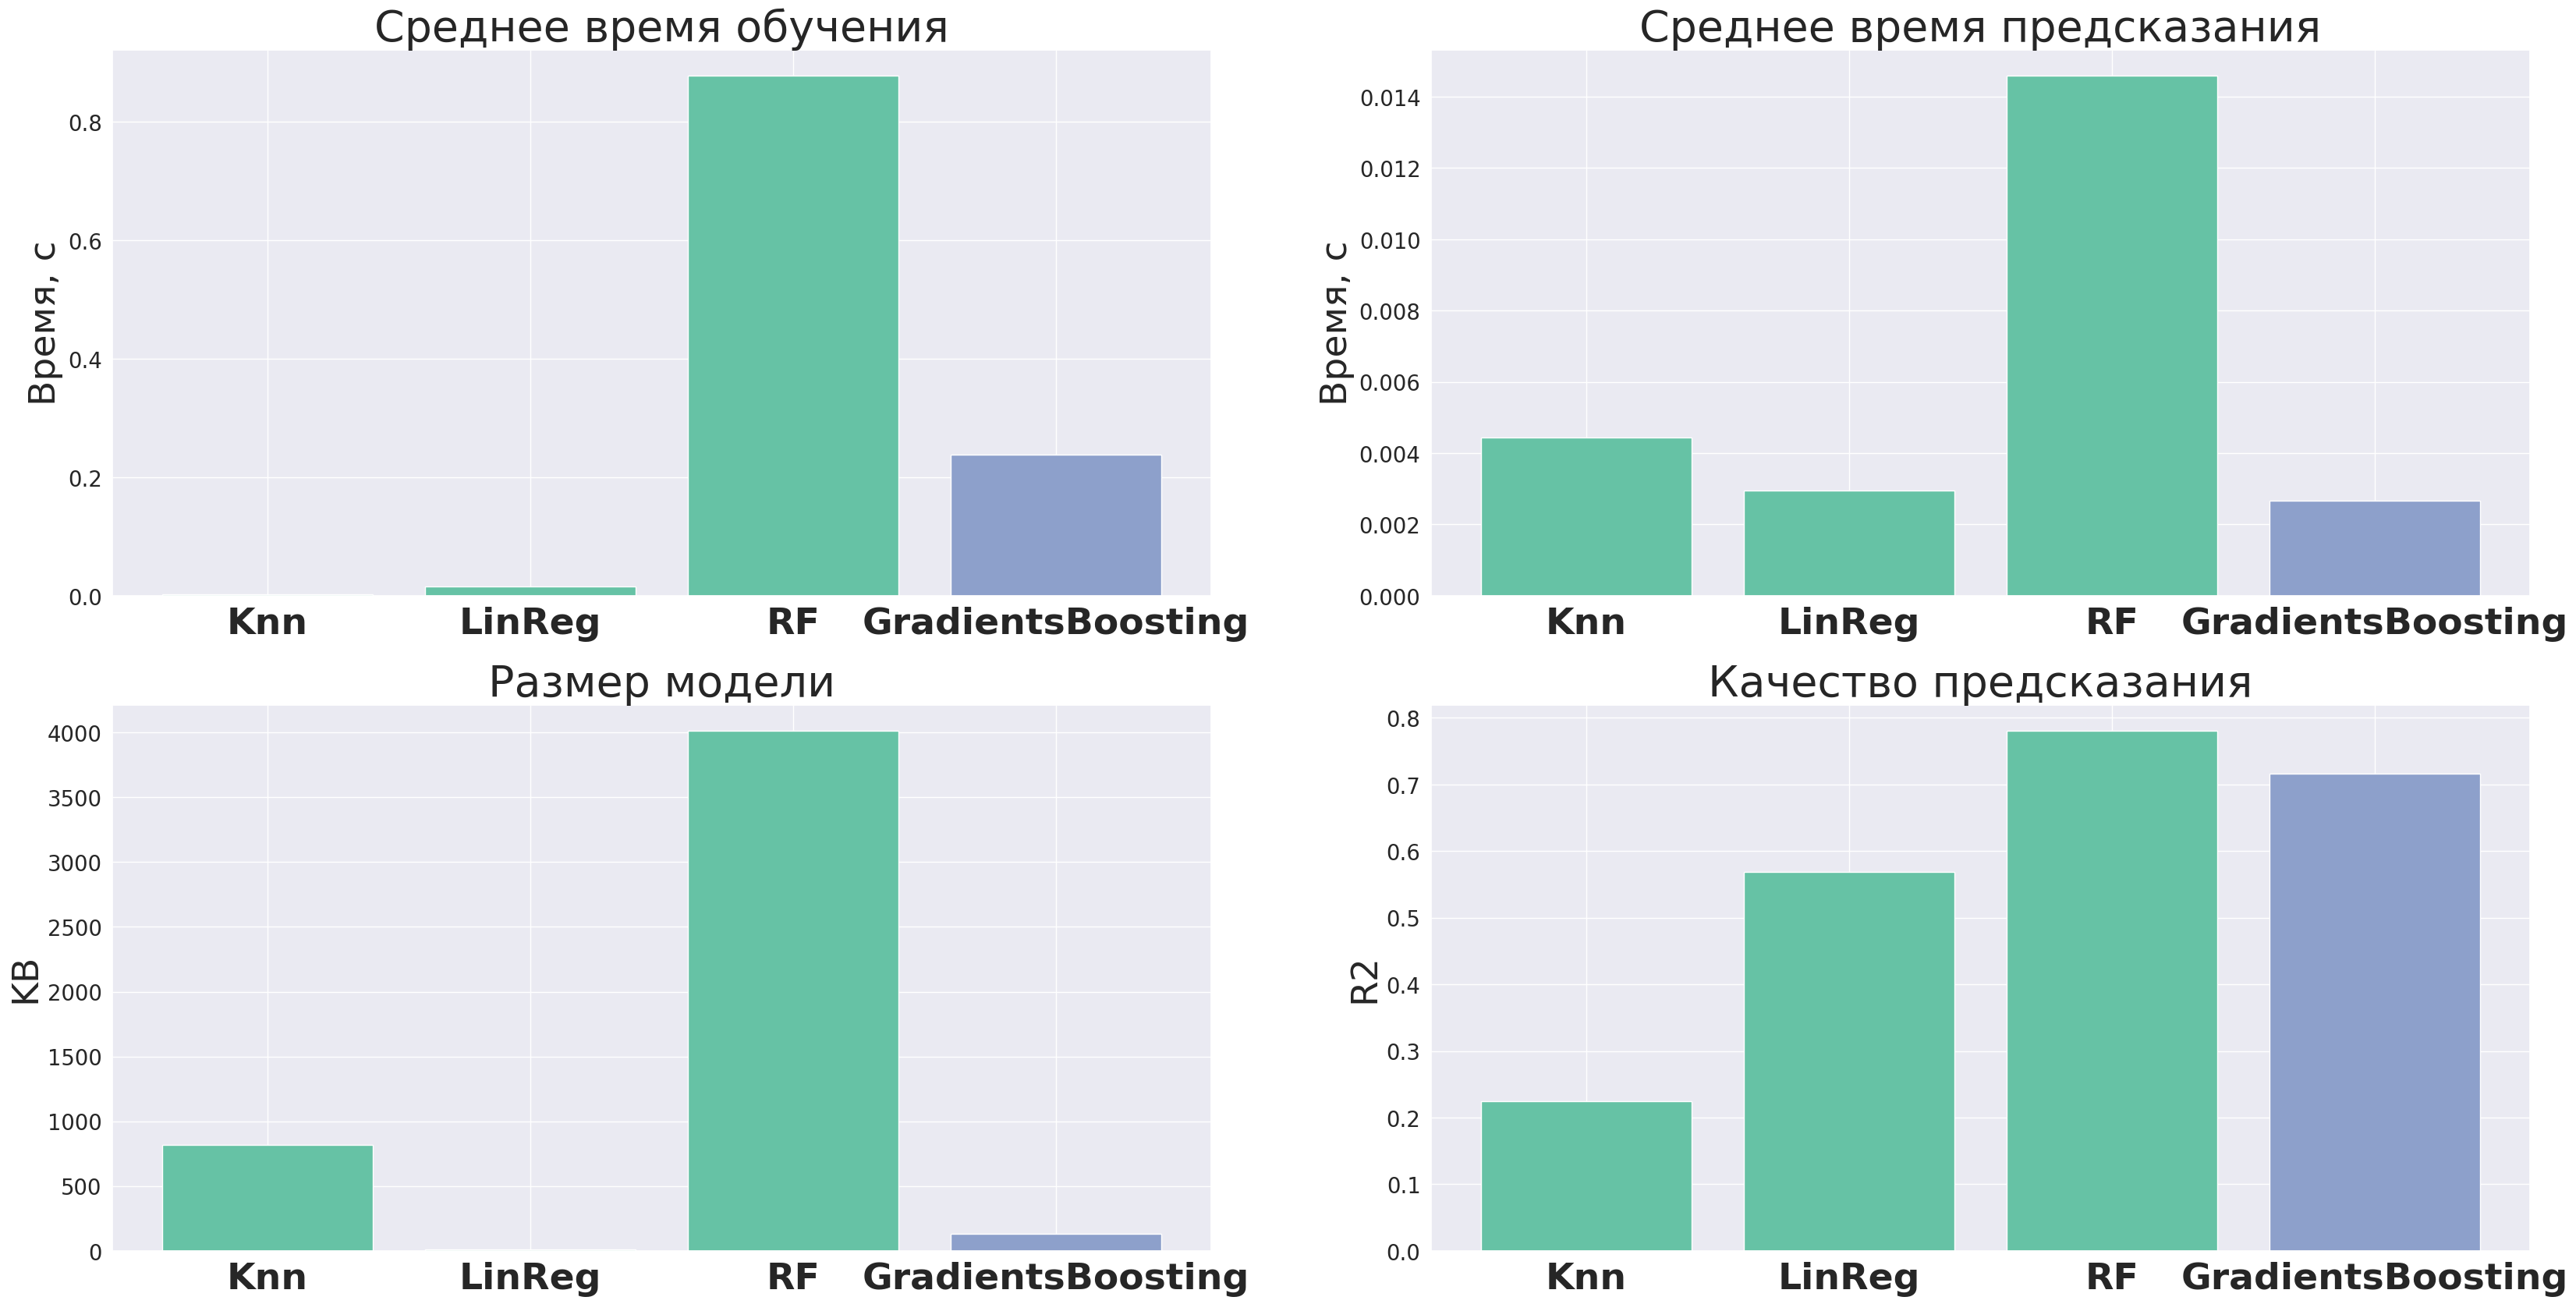

In [29]:
models = [
    KNeighborsRegressor(),
    LinearRegression(),
    RandomForestRegressor(n_jobs=1),
    GradientBoostingRegressor(),
]
labels = ["Knn", "LinReg", "RF", "GradientsBoosting"]
colors = ["#66c2a5", "#66c2a5", "#66c2a5", "#8da0cb"]

plot_compare_model_performance(
    models, X_train_encoded, X_test_encoded, y_train, y_test, labels, colors
)


При сравнимом времени обучения, время предсказания случайного леса во много раз выше, чем у градиентного бустинга. Но при этом модель градиентного бустинга все еще не дотягивает по качеству.

### 4.1 Оценка гиперпараметров градиентного бустинга

Как мы видели на эксперементах выше, гиперпараметры могут сильно влиять на работу модели. Но все это время мы оценивали только качество предсказаний. Теперь дополнительно исследуем времена обучения и предсказания в зависимости от числа деревьев бустинга.

In [30]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_encoded, y_train, test_size=0.2, random_state=RANDOM_STATE
)


&#x2753; **Вопрос** &#x2753;


> Как увеличение числа базовых моделей в модели градиентного бустинга может повлиять на скорость обучения и предсказания?


<details>
 <summary> Кликни для показа ответа </summary>

 > ⬇️ Давайте посчитаем ⬇️

</details><br/>

Введем вспомогательную функцию для отрисовки кривых.

In [31]:
def plot_compare_estimators(
    param_grid: Sequence[Union[float, int, str]],
    metrics: Sequence[Sequence[float]],
    metrics_label: Sequence[str],
    param_label: str = "",
) -> None:
    """Функция для построения графиков зависимости целевой метрики
    от некоторого параметра модели на обучающей и на валидационной
    выборке.

    :param estimator_labels: массив названий моделей
    :param param_grid: значения исследуемого параметра
    :param metrics: массив, где i-ый элемент -
        это массив значений i-ой характеристики модели
    :param param_label: названия параметра
    :param metrics_label: название метрики
    :param title: заголовок для графика
    """

    for i, metric in enumerate(metrics):

        plt.subplot(1, len(metrics), i + 1)
        plt.plot(
            param_grid,
            metric,
            linewidth=3,
            alpha=0.9,
        )
        plt.tight_layout(pad=3.0)
        plt.xlabel(param_label)
        plt.ylabel(metrics_label[i])

Обучим модели градиентного бустинга и случайного леса, варьируя число деревьев.

In [32]:
r2_test = []
predict_time = []
fit_time = []
size = []

# Сетка значений количества деревьев в бустинге
n_estimators_grid = range(1, 4000, 200)

for n_estimators in tqdm(n_estimators_grid):

    # Задаем и обучаем модель
    model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=0.025)
    results = evaluate_model_performance(model, X_train, X_val, y_train, y_val)

    # Делаем предсказания, считаем и сохраняем метрики
    fit_time.append(np.mean(results[0]))
    predict_time.append(np.mean(results[1]))
    size.append(np.mean(results[2]))
    r2_test.append(np.mean(results[3]))

100%|██████████| 20/20 [14:14<00:00, 42.71s/it]


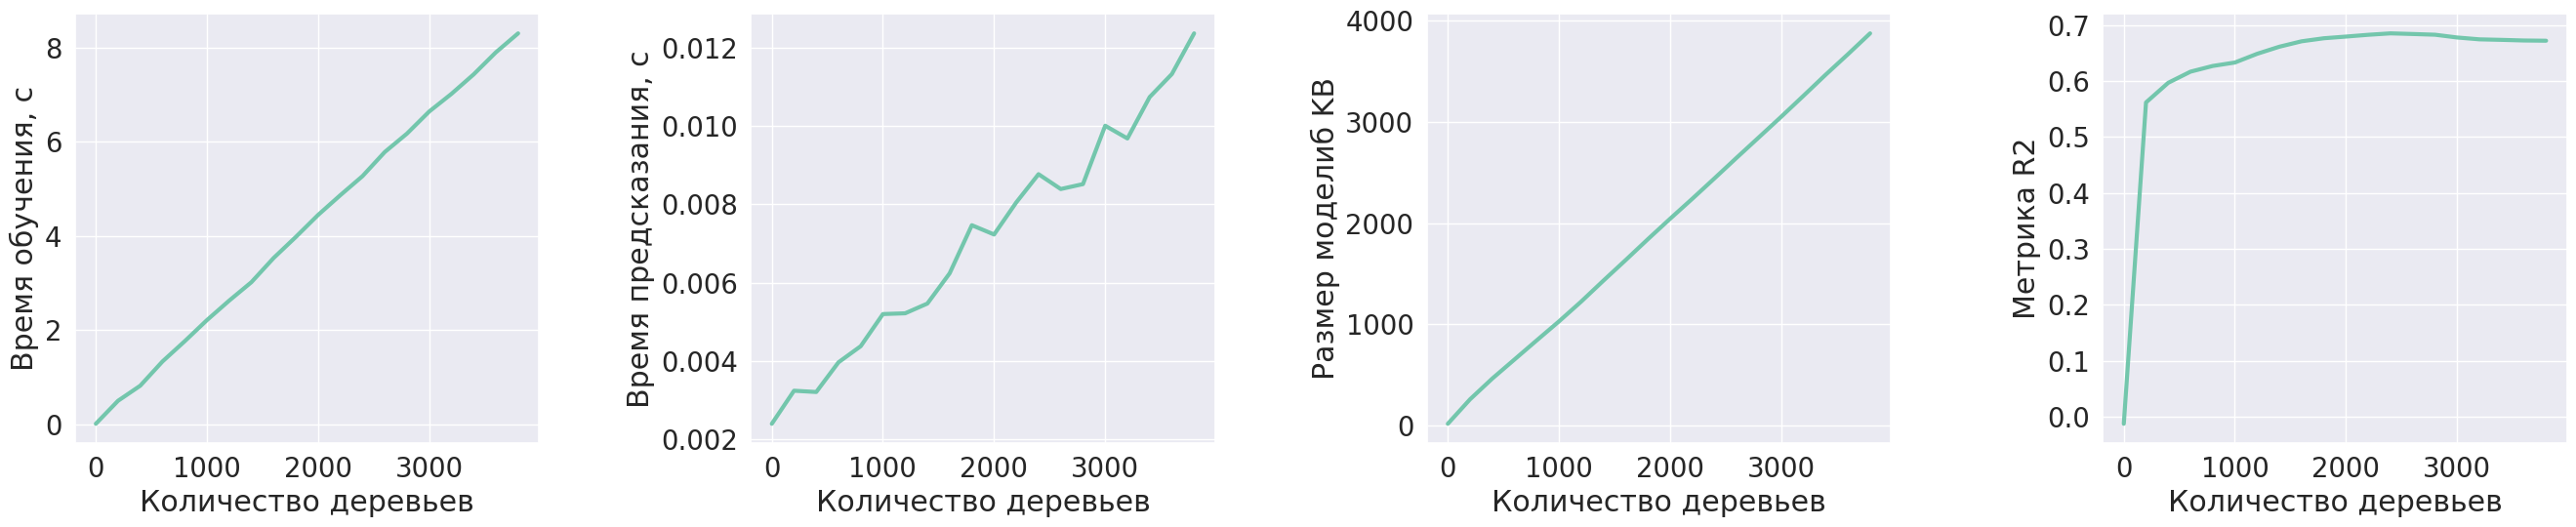

In [33]:
metrics_label = ["Время обучения, c", "Время предсказания, c", "Размер моделиб KB", "Метрика R2"]
performance = [fit_time, predict_time, size, r2_test]

plt.figure(figsize=(28, 7))

plot_compare_estimators(n_estimators_grid, performance, metrics_label, "Количество деревьев")

Объясним результаты эксперимента:

1. Время обучения &mdash; возрастает **линейно**
> Процесс последовательный. Чтобы добавить очередное дерево, алгоритму нужно рассчитать градиенты от текущего ансамбля и обучить новое дерево. Чем больше деревьев, тем больше таких итераций.
2. Время предсказания &mdash; возрастает **линейно**
> Для получения предсказания новый объект нужно "прогнать" через каждое дерево в ансамбле и усреднить результаты. Больше деревьев = больше операций прохода по деревьям. Это одна из причин, почему очень большие модели могут быть медленными в продакшене.
3. Размер модели &mdash; возрастает **линейно**
> Память требуется для хранения структуры каждого дерева (узлы, разделяющие правила, листовые значения). Каждое новое дерево — это дополнительный объём данных, который нужно сохранить. Размер одного дерева зависит от его глубины.
4. Качество предсказаний &mdash; Сначала **резко улучшается**, затем выходит на **плато**, а после может начаться очень **медленное ухудшение** (переобучение).
> Каждое новое дерево учится исправлять ошибки предыдущих. Поначалу это очень эффективно. Но после определённого момента модель начинает запоминать шум в данных, а не общие закономерности.

### 4.2 Подбор параметров градиентного бустинга

Изменение одного параметра в пользу лучшего качества предсказания так же сильно влияет на другие аспекты модели. Подберем лучшие гиперпараметры с точки зрения качества и оценим, как это повлияет на другие характеристики модели.

Для поиска гиперпараметров будем использовать `RandomSearchCV`. Зададим сетку значчений

In [34]:
gb_gridsearch = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=RANDOM_STATE),
    param_distributions={
        "n_estimators": np.arange(100, 5000, 250),
        "max_depth": np.arange(3, 10),
        "learning_rate": np.linspace(0.05, 0.5, 100),
    },
    cv=5,  # разбиение выборки на 5 фолдов
    verbose=1,  # насколько часто печатать сообщения
    n_jobs=-1,  # кол-во параллельных процессов
    n_iter=50,  # кол-во итераций случайного выбора гиперпараметров
    random_state=RANDOM_STATE,  # seed для фиксирования случайности
)

Выполним поиск по сетке значений

In [35]:
%%time
# выполняем поиск по сетке
gb_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
CPU times: user 10.9 s, sys: 1.21 s, total: 12.1 s
Wall time: 24min 25s


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.05      , 0.05454545, 0.05909091, 0.06363636, 0.06818182,
       0.07272727, 0.07727273, 0.08181818, 0.08636364, 0.09090909,
       0.09545455, 0.1       , 0.10454545, 0.10909091, 0.11363636,
       0.11818182, 0.12272727, 0.12727273, 0.13181818, 0.13636364,
       0....
       0.41363636, 0.41818182, 0.42272727, 0.42727273, 0.43181818,
       0.43636364, 0.44090909, 0.44545455, 0.45      , 0.45454545,
       0.45909091, 0.46363636, 0.46818182, 0.47272727, 0.47727273,
       0.48181818, 0.48636364, 0.49090909, 0.49545455, 0.5       ]),
                                        'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 100,  350,  600,  850, 1100, 1350, 1600, 1850, 2100, 2350, 2600,
       2850, 3100, 3350, 3600, 3850, 4100, 4350, 4600, 4850])},
                   random_state=42, verbose=1)

In [36]:
print(gb_gridsearch.best_params_)

{'n_estimators': np.int64(2850), 'max_depth': np.int64(3), 'learning_rate': np.float64(0.2181818181818182)}


*Для справки*: дефолтные значения параметров в sklearn
* `learning_rate` = 0.1
* `n_estimators` = 100
* `max_depth` = 3

Сравним, как подбор гиперпараметров повлиял на общую производительность модели.

In [40]:
y_pred = gb_gridsearch.predict(X_test_encoded)
r2_score(y_test, y_pred)

0.7001691561028142

**GB vs RF:** Градиентный бустинг с подобранными параметрами не только показал лучшее качество, но и предсказывает быстрее, чем случайный лес сопоставимого качества. Это важное преимущество бустинга в продакшене, где скорость инференса критична.

 Модель с параметрами по умолчанию (GB) демонстрирует неплохой баланс: хорошее качество, очень быстрое обучение и предсказание, и малый размер. Это напоминает, что слепой поиск гиперпараметров не всегда оправдан — нужно учитывать ограничения вычислительных ресурсов и требования задачи.

---
© 2025 команда <a href="https://thetahat.ru/">ThetaHat</a> для курса ML-1 ШАД